In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import math

import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support 

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
# from statsmodels.regression.linear_model import OLS as ols

# NLP
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string
# import cufflinks as cf
# from autoviml.Auto_NLP import Auto_NLP

#TF
import tensorflow as tf
# import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



## 1. Data Acquisition

In [2]:
path = "Data"
labelled_raw = pd.read_csv(path+"/deceptive-opinion.csv")
unlabelled_raw = pd.read_csv(path+"/fine-foods.csv",engine='python',error_bad_lines=False)

In [3]:
labelled_raw

deceptive             hotel  polarity       source                                               text
0      truthful            conrad  positive  TripAdvisor  We stayed for a one night getaway with family ...
1      truthful             hyatt  positive  TripAdvisor  Triple A rate with upgrade to view room was le...
2      truthful             hyatt  positive  TripAdvisor  This comes a little late as I'm finally catchi...
3      truthful              omni  positive  TripAdvisor  The Omni Chicago really delivers on all fronts...
4      truthful             hyatt  positive  TripAdvisor  I asked for a high floor away from the elevato...
...         ...               ...       ...          ...                                                ...
1595  deceptive  intercontinental  negative        MTurk  Problems started when I booked the InterContin...
1596  deceptive            amalfi  negative        MTurk  The Amalfi Hotel has a beautiful website and i...
1597  deceptive  intercontinental  negative        MTurk  The Intercontinental Chicago Magnificent Mile ...
1598  deceptive            palmer  negative        MTurk  The Palmer House Hilton, while it looks good i...
1599  deceptive            amalfi  negative        MTurk  As a former Chicagoan, I'm appalled at the Ama...

[1600 rows x 5 columns]

In [4]:
unlabelled_raw

Id   ProductId          UserId                      ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score        Time                             Summary                                               Text
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian                     1                       1      5  1303862400               Good Quality Dog Food  I have bought several of the Vitality canned d...
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa                     0                       0      1  1346976000                   Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"                     1                       1      4  1219017600               "Delight" says it all  This is a confection that has been around a fe...
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl                     3                       3      2  1307923200                      Cough Medicine  If you are looking for the secret ingredient i...
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"                     0                       0      5  1350777600                         Great taffy  Great taffy at a great price.  There was a wid...
...        ...         ...             ...                              ...                   ...                     ...    ...         ...                                 ...                                                ...
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter                     0                       0      5  1299628800                 Will not do without  Great for sesame chicken..this is a good if no...
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer                     0                       0      2  1331251200                        disappointed  I'm disappointed with the flavor. The chocolat...
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"                     2                       2      5  1329782400            Perfect for our maltipoo  These stars are small, so you can give 10-15 o...
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"                     1                       1      5  1331596800  Favorite Training and reward treat  These are the BEST treats for training and rew...
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17                     0                       0      5  1338422400                         Great Honey  I am very satisfied ,product is as advertised,...

[568454 rows x 10 columns]

In [5]:
df1 = labelled_raw
df2 = unlabelled_raw

## 2. EDA
<br>

### Hotel dataset

In [6]:
def clean_text(text):  
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)  #  square brackets
    text = re.sub("\\W"," ",text) #  special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)  #  urls
    text = re.sub('<.*?>+', '', text)  
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)   # punctuations
    text = re.sub('\n', '', text)   # new line
    text = re.sub('\w*\d\w*', '', text)  # words containing number
    return text

def missing_value_pc(df):
    missing_df = pd.DataFrame(round((df.isnull().sum()/len(df)*100),2).sort_values(ascending=False))
    return missing_df.head(60)

def drop_mv_greater_than_75_pc(df):
    # Dropping Missing values > 75%
    df_1 = df.dropna(thresh=len(df)/3, axis=1)
    return df_1

def drop_duplicates(df,subset,cols_to_drop):
    df.drop_duplicates(subset = subset, inplace=True)
    df.drop(cols_to_drop,axis=1,inplace=True)
    return df_1

def corr_heatmap(df):
    plt.figure(figsize = (40,20))        
    sns.heatmap(df.corr(),annot = True, cmap = 'YlGnBu')
    plt.show()   

### Data Exploration

In [7]:
print('Missing Values Percentage\n')
print(missing_value_pc(df1))
print('\nHotels')
print(df1['hotel'].value_counts())
print('\nDeceptive Counts')
print(df1.deceptive.value_counts())
print('\nPolarity Counts')
print(df1.polarity.value_counts())


Missing Values Percentage

             0
deceptive  0.0
hotel      0.0
polarity   0.0
source     0.0
text       0.0

Hotels
monaco              80
amalfi              80
hardrock            80
hyatt               80
talbott             80
intercontinental    80
sofitel             80
james               80
fairmont            80
swissotel           80
sheraton            80
hilton              80
palmer              80
allegro             80
ambassador          80
omni                80
affinia             80
conrad              80
knickerbocker       80
homewood            80
Name: hotel, dtype: int64

Deceptive Counts
truthful     800
deceptive    800
Name: deceptive, dtype: int64

Polarity Counts
positive    800
negative    800
Name: polarity, dtype: int64


In [8]:
df1['text']

0       We stayed for a one night getaway with family ...
1       Triple A rate with upgrade to view room was le...
2       This comes a little late as I'm finally catchi...
3       The Omni Chicago really delivers on all fronts...
4       I asked for a high floor away from the elevato...
                              ...                        
1595    Problems started when I booked the InterContin...
1596    The Amalfi Hotel has a beautiful website and i...
1597    The Intercontinental Chicago Magnificent Mile ...
1598    The Palmer House Hilton, while it looks good i...
1599    As a former Chicagoan, I'm appalled at the Ama...
Name: text, Length: 1600, dtype: object

In [9]:
df1['text'] = df1['text'].apply(clean_text)

# Changing Deceptive and Polarity to numerical values
df1['deceptive'] = np.where(df1['deceptive'] == 'deceptive',1,0)
df1['polarity'] = np.where(df1['polarity'] == 'positive',1,0)

df1

deceptive             hotel  polarity       source                                               text
0             0            conrad         1  TripAdvisor  we stayed for a one night getaway with family ...
1             0             hyatt         1  TripAdvisor  triple a rate with upgrade to view room was le...
2             0             hyatt         1  TripAdvisor  this comes a little late as i m finally catchi...
3             0              omni         1  TripAdvisor  the omni chicago really delivers on all fronts...
4             0             hyatt         1  TripAdvisor  i asked for a high floor away from the elevato...
...         ...               ...       ...          ...                                                ...
1595          1  intercontinental         0        MTurk  problems started when i booked the intercontin...
1596          1            amalfi         0        MTurk  the amalfi hotel has a beautiful website and i...
1597          1  intercontinental         0        MTurk  the intercontinental chicago magnificent mile ...
1598          1            palmer         0        MTurk  the palmer house hilton  while it looks good i...
1599          1            amalfi         0        MTurk  as a former chicagoan  i m appalled at the ama...

[1600 rows x 5 columns]

In [10]:
# Dataset Shape and Memory Usage
print('Labelled Set Shape = {}'.format(df1.shape))
print('Labelled Set Memory Usage = {:.2f} MB'.format(df1.memory_usage().sum() / 1024**2))
print('Unlablelled Set Shape = {}'.format(df2.shape))
print('Unlablelled Set Memory Usage = {:.2f} MB'.format(df2.memory_usage().sum() / 1024**2))

Labelled Set Shape = (1600, 5)
Labelled Set Memory Usage = 0.06 MB
Unlablelled Set Shape = (568454, 10)
Unlablelled Set Memory Usage = 43.37 MB


In [11]:
# Cardinality
print(f'Number of unique values in text = {df1["text"].nunique()} (Labelled) - {df2["Text"].nunique()} (Unlabelled)')

Number of unique values in text = 1596 (Labelled) - 393579 (Unlabelled)


## 3. Text Processing

### 3.1 Meta Features

### Meta Features:
`word_count` number of words in text <br>
`unique_word_count` number of unique words in text <br>
`stop_word_count` number of stop words in text <br>
`url_count number` of urls in text <br>
`mean_word_length` average character count in words <br>
`char_count number` of characters in text <br>
`punctuation_count` number of punctuations in text <br>
`hashtag_count` number of hashtags (#) in text <br>
`mention_count` number of mentions (@) in text <br>

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import nltk

from nltk.tokenize import sent_tokenize  # Sentence tokenizer

from nltk.tokenize import word_tokenize  # Word tokenizer

from nltk.probability import FreqDist  # Frequency Distribution

from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'so', 'but', 'down', 'same', 'which', 'just', 'themselves', 'these', 'below', 'with', 'was', "mustn't", 'his', 'he', 'too', "should've", 'won', 'myself', 'through', 'own', 'mustn', 'under', 've', 'me', "shan't", 'had', 'haven', 'does', 'yours', "mightn't", 'll', 'shouldn', 'will', 'i', 'into', 'while', 'him', "hasn't", 'can', "it's", 'the', 'whom', 'over', 'where', 'nor', 'if', "didn't", 'are', "don't", 'm', 'each', 'be', 'this', 'd', 'you', 'himself', 'as', 'those', 'most', 'any', 'what', 'its', 'some', 'very', 'your', 'of', 'yourselves', 'until', 'than', 'their', "aren't", 'didn', 'only', 'o', 'because', 'hers', "you've", 'who', 'off', 'doing', 'having', 'above', 'such', 'wouldn', 'yourself', "won't", 'once', "you'll", 'between', 'wasn', 'other', 'there', 'aren', 'when', 'do', 'no', 'further', 'to', 't', 'more', "you'd", 'after', 'why', 'couldn', 'doesn', 'am', 'were', "needn't", "she's", 'have', 'not', 'few', 'during', 'from', "couldn't", 'our', 'being', "you're", 'needn', 'theirs'

In [ ]:
# word_count
df1['word_count'] = df1['text'].apply(lambda x: len(str(x).split()))
df2['word_count'] = df2['Text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df1['unique_word_count'] = df1['text'].apply(lambda x: len(set(str(x).split())))
df2['unique_word_count'] = df2['Text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df1['stop_word_count'] = df1['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
df2['stop_word_count'] = df2['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
df1['url_count'] = df1['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df2['url_count'] = df2['Text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df1['mean_word_length'] = df1['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df2['mean_word_length'] = df2['Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df1['char_count'] = df1['text'].apply(lambda x: len(str(x)))
df2['char_count'] = df2['Text'].apply(lambda x: len(str(x)))

# punctuation_count
df1['punctuation_count'] = df1['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df2['punctuation_count'] = df2['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df1['hashtag_count'] = df1['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df2['hashtag_count'] = df2['Text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df1['mention_count'] = df1['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df2['mention_count'] = df2['Text'].apply(lambda x: len([c for c in str(x) if c == '@']))

/opt/Anaconda3-2020.02-Linux-x86_64/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/Anaconda3-2020.02-Linux-x86_64/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/Anaconda3-2020.02-Linux-x86_64/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/Anaconda3-2020.02-Linux-x86_64/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/Anaconda3-2020.02-Linux-x86_64/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg

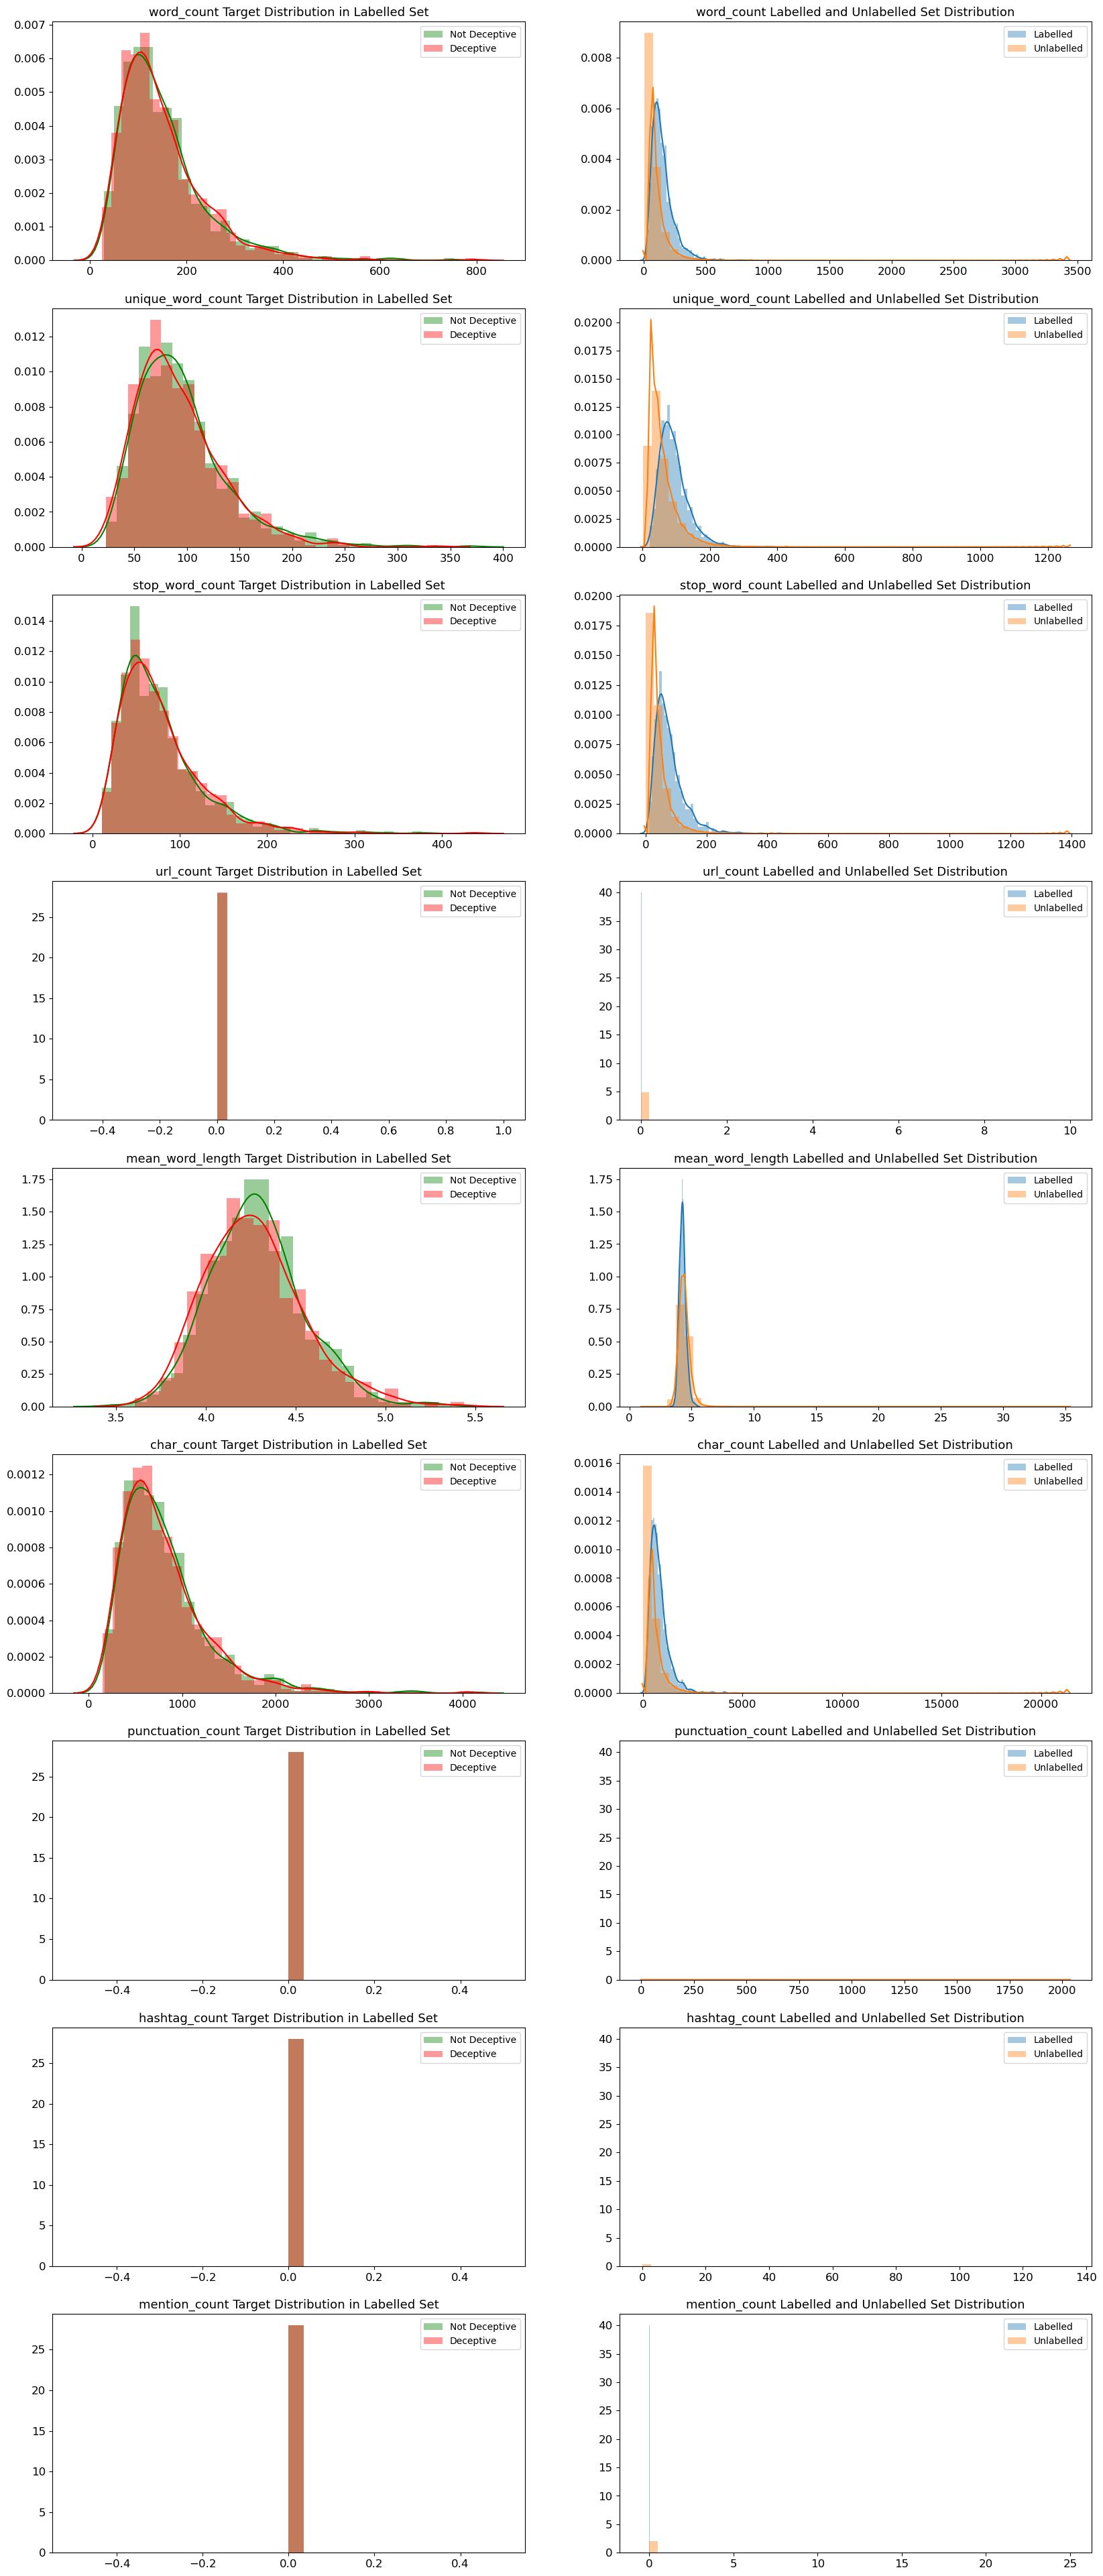

In [15]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DECEPTIVE = df1['deceptive'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df1.loc[~DECEPTIVE][feature], label='Not Deceptive', ax=axes[i][0], color='green')
    sns.distplot(df1.loc[DECEPTIVE][feature], label='Deceptive', ax=axes[i][0], color='red')

    sns.distplot(df1[feature], label='Labelled', ax=axes[i][1])
    sns.distplot(df2[feature], label='Unlabelled', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Labelled Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Labelled and Unlabelled Set Distribution', fontsize=13)

plt.show()

### 3.2 Class balance Check

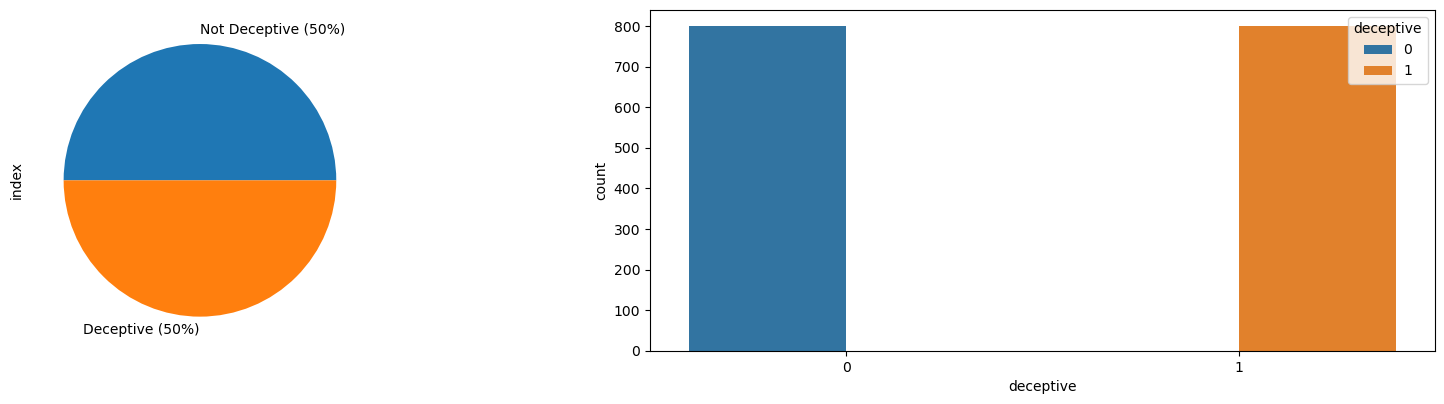

In [16]:
df1 = df1.reset_index()
# df1.id = df1.level_0

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df1.groupby('deceptive').count()['index'].plot(kind='pie', ax=axes[0], labels=['Not Deceptive (50%)', 'Deceptive (50%)'])
sns.countplot(x=df1['deceptive'], hue=df1['deceptive'], ax=axes[1])

### 3.3 n-grams

In [17]:
from collections import defaultdict

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

            # Unigrams
deceptive_unigrams = defaultdict(int)
nondeceptive_unigrams = defaultdict(int)

for review in df1[DECEPTIVE]['text']:
    for word in generate_ngrams(review):
        deceptive_unigrams[word] += 1
        
for review in df1[~DECEPTIVE]['text']:
    for word in generate_ngrams(review):
        nondeceptive_unigrams[word] += 1
        
df_deceptive_unigrams = pd.DataFrame(sorted(deceptive_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondeceptive_unigrams = pd.DataFrame(sorted(nondeceptive_unigrams.items(), key=lambda x: x[1])[::-1])

            # Bigrams
deceptive_bigrams = defaultdict(int)
nondeceptive_bigrams = defaultdict(int)

for review in df1[DECEPTIVE]['text']:
    for word in generate_ngrams(review, n_gram=2):
        deceptive_bigrams[word] += 1
        
for review in df1[~DECEPTIVE]['text']:
    for word in generate_ngrams(review, n_gram=2):
        nondeceptive_bigrams[word] += 1
        
df_deceptive_bigrams = pd.DataFrame(sorted(deceptive_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondeceptive_bigrams = pd.DataFrame(sorted(nondeceptive_bigrams.items(), key=lambda x: x[1])[::-1])

        # Trigrams
deceptive_trigrams = defaultdict(int)
nondeceptive_trigrams = defaultdict(int)

for review in df1[DECEPTIVE]['text']:
    for word in generate_ngrams(review, n_gram=3):
        deceptive_trigrams[word] += 1
        
for review in df1[~DECEPTIVE]['text']:
    for word in generate_ngrams(review, n_gram=3):
        nondeceptive_trigrams[word] += 1
        
df_deceptive_trigrams = pd.DataFrame(sorted(deceptive_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondeceptive_trigrams = pd.DataFrame(sorted(nondeceptive_trigrams.items(), key=lambda x: x[1])[::-1])

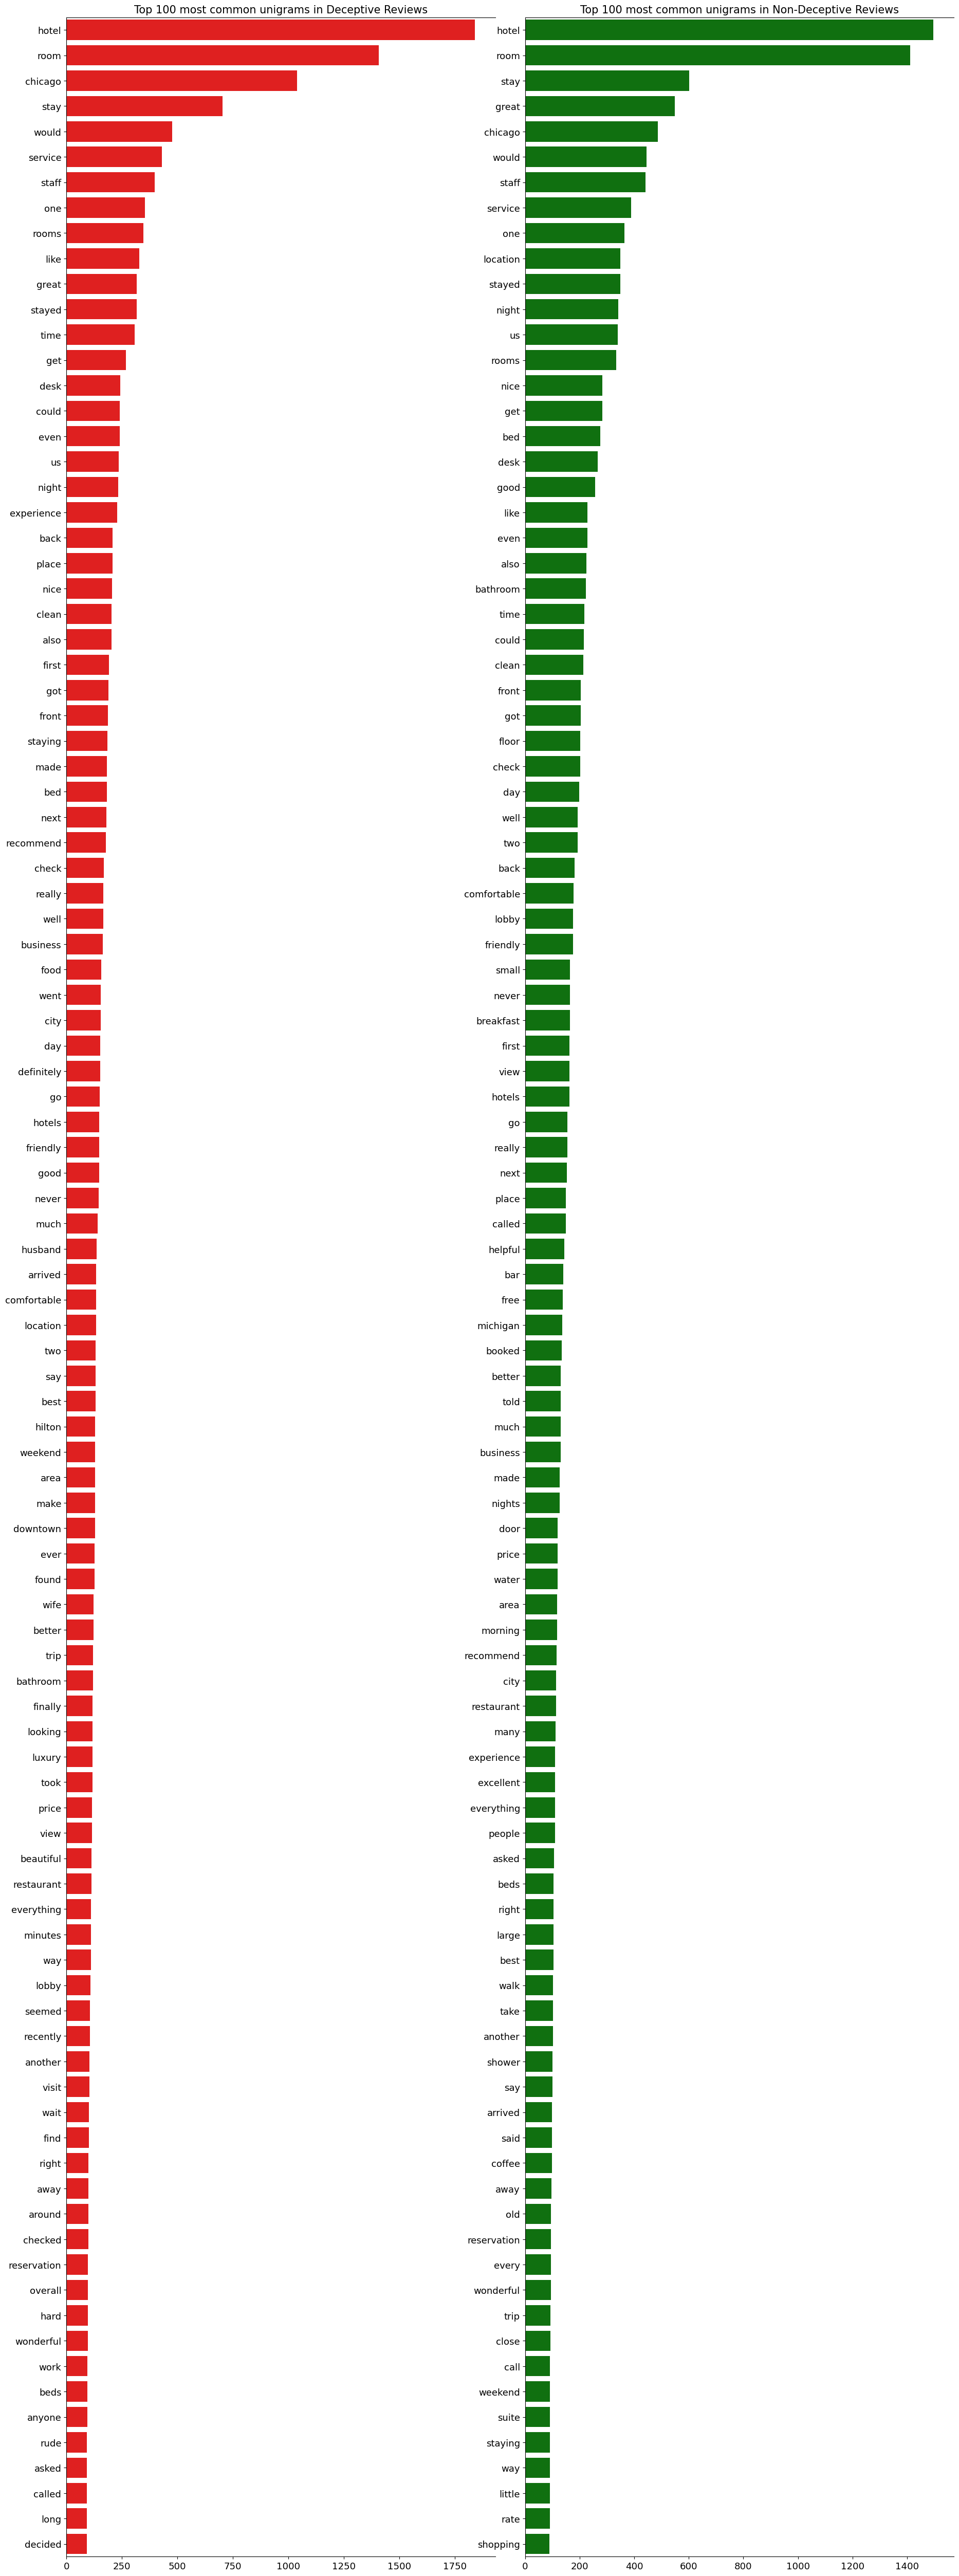

In [18]:
# Unigrams
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_deceptive_unigrams[0].values[:N], x=df_deceptive_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondeceptive_unigrams[0].values[:N], x=df_nondeceptive_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Deceptive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-Deceptive Reviews', fontsize=15)

plt.show()

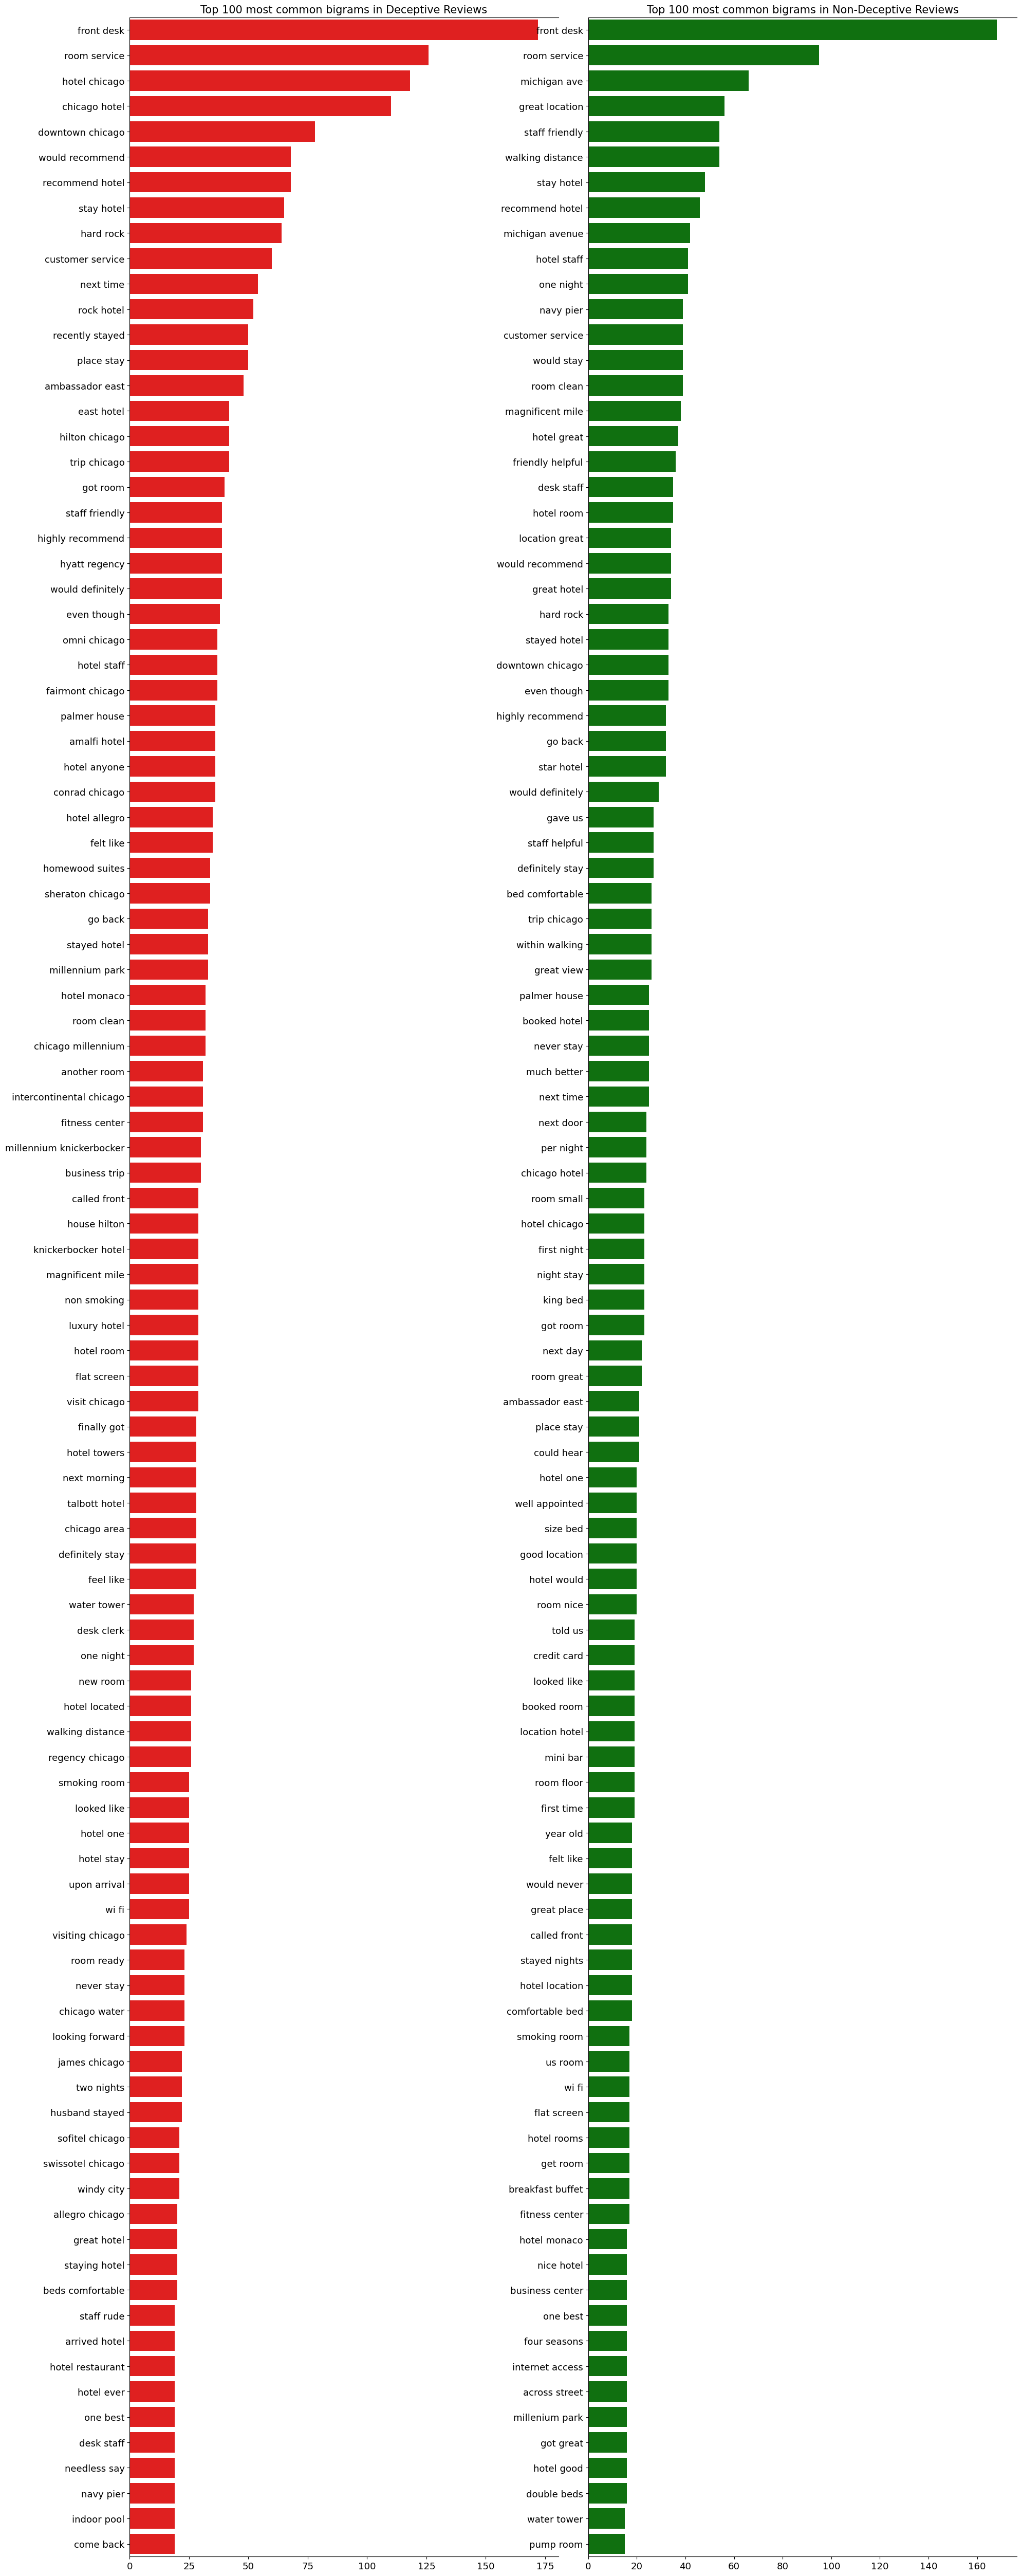

In [19]:
# Bi-grams:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_deceptive_bigrams[0].values[:N], x=df_deceptive_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondeceptive_bigrams[0].values[:N], x=df_nondeceptive_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Deceptive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-Deceptive Reviews', fontsize=15)

plt.show()

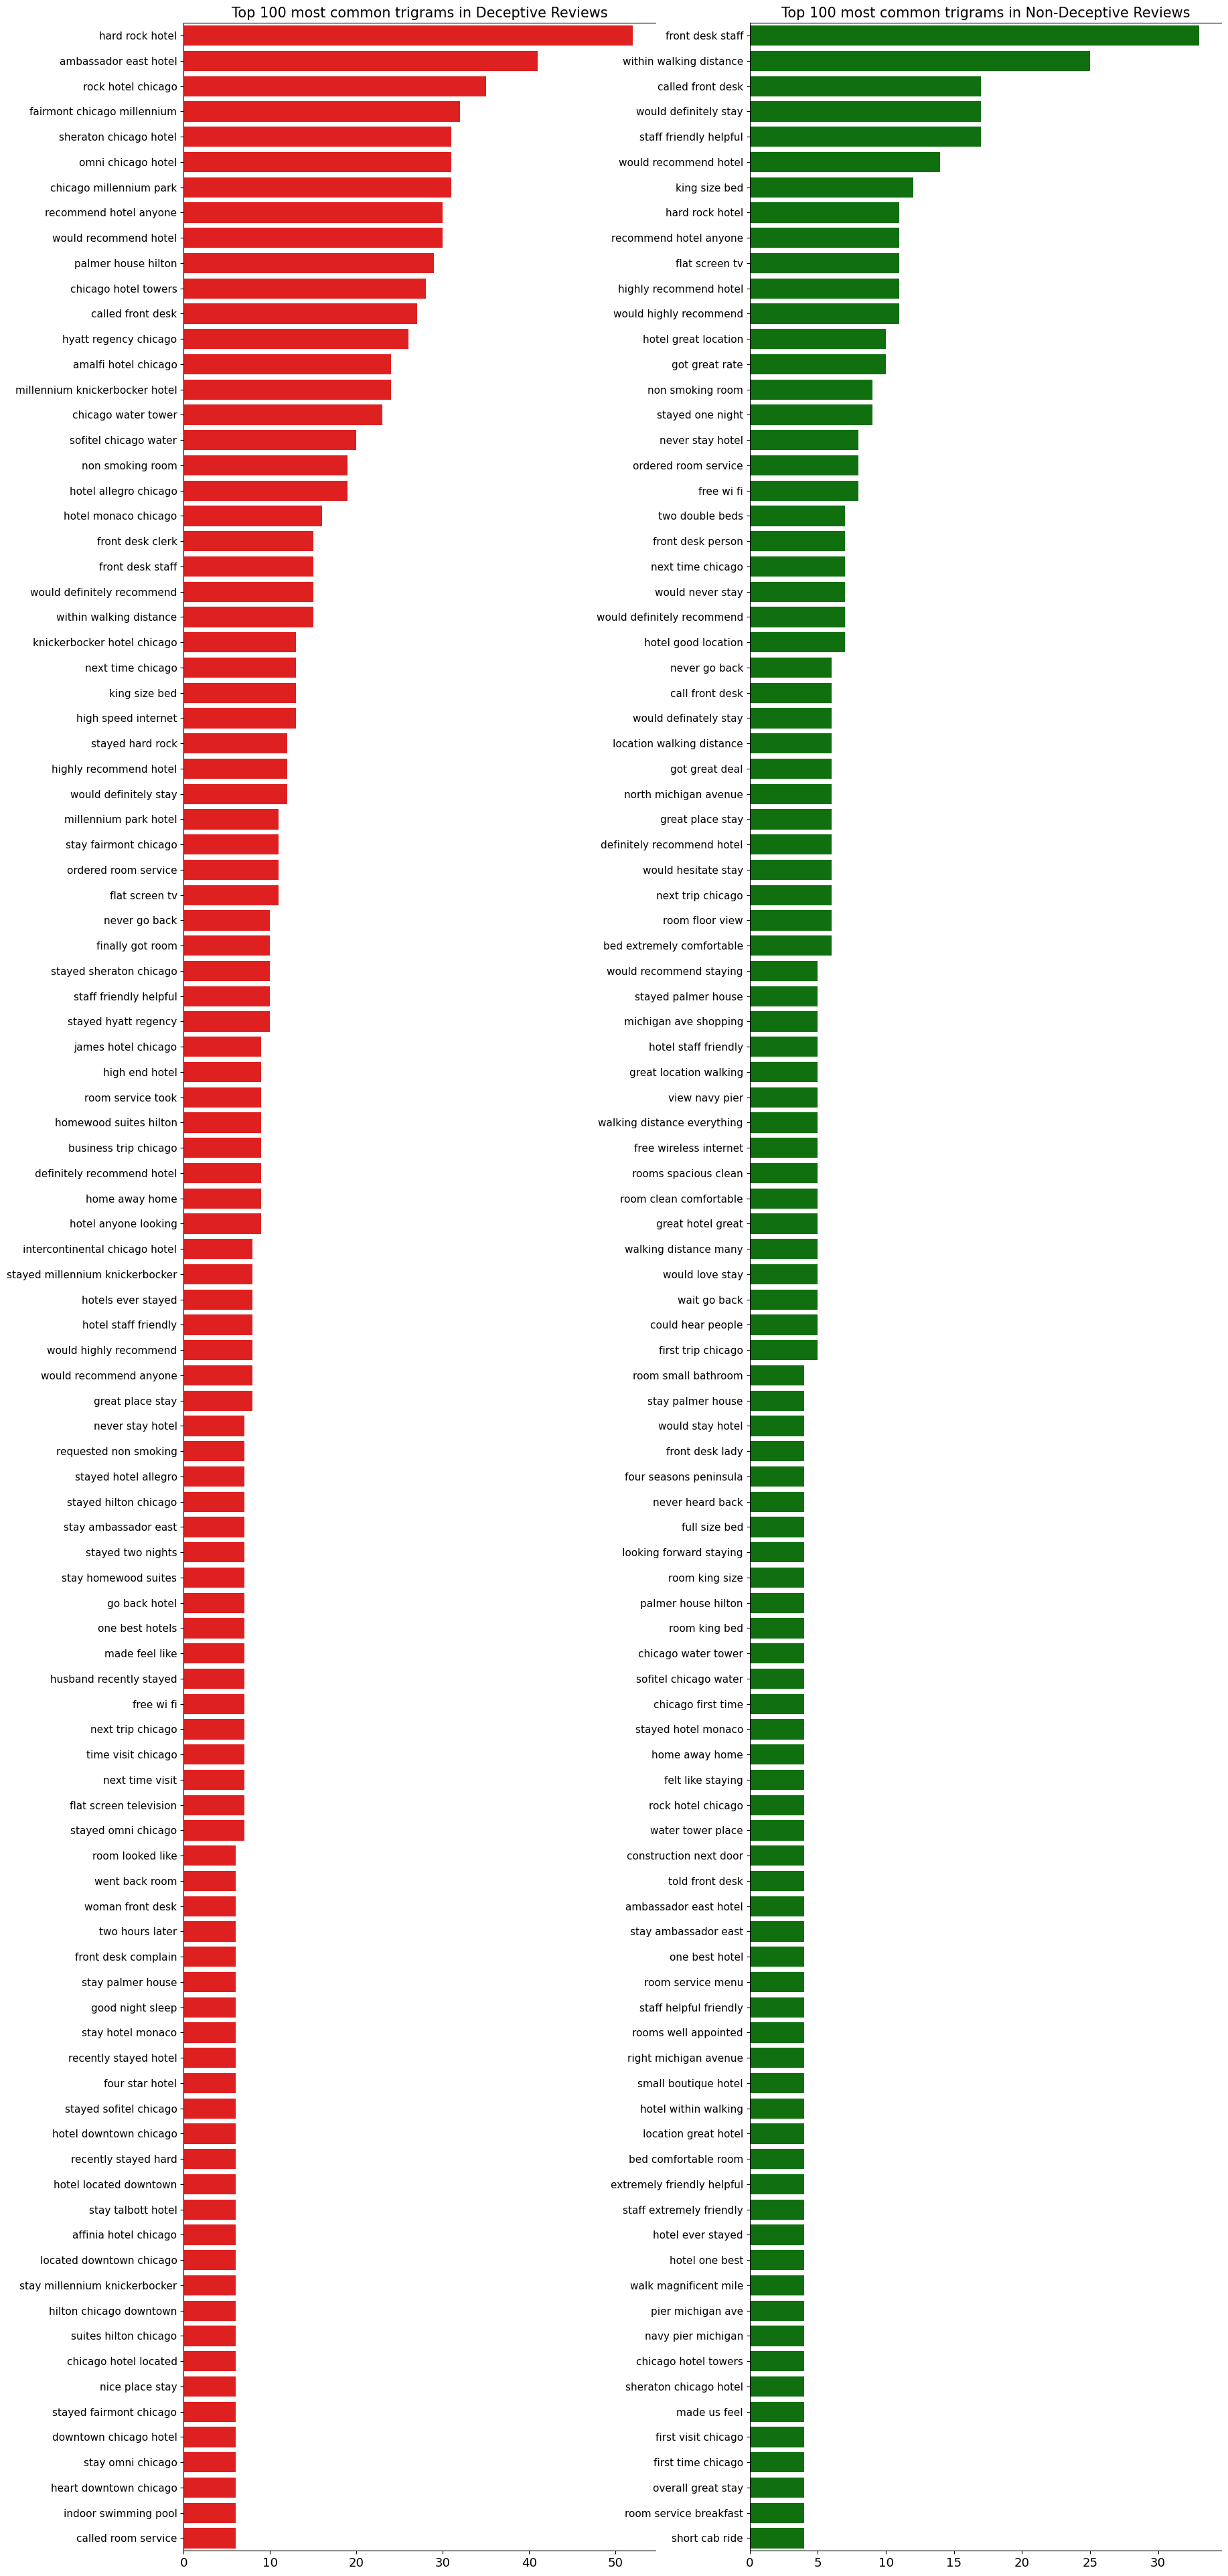

In [20]:
# Tri-grams
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_deceptive_trigrams[0].values[:N], x=df_deceptive_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondeceptive_trigrams[0].values[:N], x=df_nondeceptive_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Deceptive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-Deceptive Reviews', fontsize=15)

plt.show()

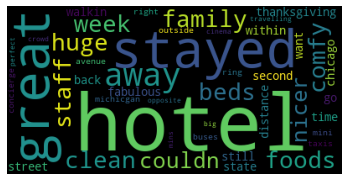

In [21]:
# Word Cloud:
from wordcloud import WordCloud, STOPWORDS

def wordcloud_100(df,text_field):
    text = df[text_field].values[100]
    wordcloud = WordCloud().generate(str(text))

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
wordcloud_100(df1,'text')

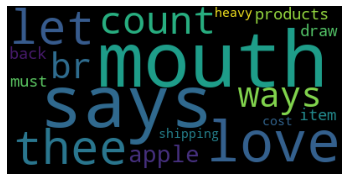

In [22]:
wordcloud_100(df2,'Text')

### 3.4 Text Processing

In [23]:
# Tokenization:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

def df_sentence_tokenize(df,text_field):
    df['tokenized_sents'] = df.apply(lambda row: nltk.sent_tokenize(row[text_field]),axis=1)
    df['tokenized_sents']
    return df['tokenized_sents']

def df_word_tokenize(df,text_field):
    df['tokenized_word'] = df.apply(lambda row: nltk.word_tokenize(row[text_field]),axis=1)
    df['tokenized_word']
    return df['tokenized_word']    

# Restrict word count to 180 chars:
def char_len(x, fixed_n):
    '''set string x to fixed_n character, return x if short'''
    if len(x) > fixed_n: 
        return x[:fixed_n] 
    elif len(x) < fixed_n: 
        return x + 'x' * (fixed_n - len(x)) 
    return x 

#### 3.4.1 Labelled Dataset:

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
df11 = df1.drop(['index'],axis = 1)

df_sentence_tokenize(df11,'text')
df_word_tokenize(df11,'text')

df11['text_limited'] = df11['text'].apply(lambda x:char_len(x,180))

df11

deceptive             hotel  polarity       source                                               text  word_count  unique_word_count  stop_word_count  url_count  mean_word_length  char_count  punctuation_count  hashtag_count  mention_count                                    tokenized_sents                                     tokenized_word                                       text_limited
0             0            conrad         1  TripAdvisor  we stayed for a one night getaway with family ...         103                 76               48          0          4.194175         556                  0              0              0  [we stayed for a one night getaway with family...  [we, stayed, for, a, one, night, getaway, with...  we stayed for a one night getaway with family ...
1             0             hyatt         1  TripAdvisor  triple a rate with upgrade to view room was le...          43                 37               13          0          5.255814         283                  0              0              0  [triple a rate with upgrade to view room was l...  [triple, a, rate, with, upgrade, to, view, roo...  triple a rate with upgrade to view room was le...
2             0             hyatt         1  TripAdvisor  this comes a little late as i m finally catchi...         209                134              105          0          4.119617        1097                  0              0              0  [this comes a little late as i m finally catch...  [this, comes, a, little, late, as, i, m, final...  this comes a little late as i m finally catchi...
3             0              omni         1  TripAdvisor  the omni chicago really delivers on all fronts...         126                 84               63          0          4.444444         705                  0              0              0  [the omni chicago really delivers on all front...  [the, omni, chicago, really, delivers, on, all...  the omni chicago really delivers on all fronts...
4             0             hyatt         1  TripAdvisor  i asked for a high floor away from the elevato...          73                 56               40          0          4.164384         384                  0              0              0  [i asked for a high floor away from the elevat...  [i, asked, for, a, high, floor, away, from, th...  i asked for a high floor away from the elevato...
...         ...               ...       ...          ...                                                ...         ...                ...              ...        ...               ...         ...                ...            ...            ...                                                ...                                                ...                                                ...
1595          1  intercontinental         0        MTurk  problems started when i booked the intercontin...         135                 96               65          0          4.355556         744                  0              0              0  [problems started when i booked the interconti...  [problems, started, when, i, booked, the, inte...  problems started when i booked the intercontin...
1596          1            amalfi         0        MTurk  the amalfi hotel has a beautiful website and i...         125                 86               72          0          4.256000         671                  0              0              0  [the amalfi hotel has a beautiful website and ...  [the, amalfi, hotel, has, a, beautiful, websit...  the amalfi hotel has a beautiful website and i...
1597          1  intercontinental         0        MTurk  the intercontinental chicago magnificent mile ...         140                 94               72          0          4.400000         766                  0              0              0  [the intercontinental chicago magnificent mile...  [the, intercontinental, chicago, magnificent, ...  the intercontinental chicago magnificent mile ...
1598          1 

In [27]:
print("Max word count: {}".format(df11.word_count.max()))
print("Min word count: {}".format(df11.word_count.min()))
print("Average word count: {}".format(df11.word_count.mean()))

Max word count: 797
Min word count: 25
Average word count: 149.445


#### 3.4.2 Unlabelled Dataset

In [28]:
df21 = df2.sample(n=15000, random_state = 40)
df21.reset_index(drop = True, inplace = True)

df21['Text'] = df21['Text'].apply(clean_text)
df_sentence_tokenize(df21,'Text')
df_word_tokenize(df21,'Text')

df21['text_limited'] = df21['Text'].apply(lambda x:char_len(x,180))

df21

Id   ProductId          UserId                                       ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score        Time                                            Summary                                               Text  word_count  unique_word_count  stop_word_count  url_count  mean_word_length  char_count  punctuation_count  hashtag_count  mention_count                                    tokenized_sents                                     tokenized_word                                       text_limited
0      289320  B001O2F5WQ  A30EPHX6OP244B                                        morganbaby                     0                       0      5  1298332800                                     very very good  my son loves this variety   i had a hard time ...          40                 33               19          0          4.000000         202                  7              0              0  [my son loves this variety   i had a hard time...  [my, son, loves, this, variety, i, had, a, har...  my son loves this variety   i had a hard time ...
1       57440  B003OP8LKE  A278A667ICAYTS                                          B. Laska                     0                       0      5  1326067200                                  Fantastic coffee!  this is some of the smoothest coffee i ve ever...          36                 30               17          0          4.916667         212                  8              0              0  [this is some of the smoothest coffee i ve eve...  [this, is, some, of, the, smoothest, coffee, i...  this is some of the smoothest coffee i ve ever...
2       62655  B000I1OLT2  A281NPSIMI1C2R            Rebecca of Amazon "The Rebecca Review"                     0                       0      5  1329782400              No Bitter Taste like Other Green Teas  my first impression of stash s green chai tea ...         100                 79               33          0          4.580000         557                 22              0              0  [my first impression of stash s green chai tea...  [my, first, impression, of, stash, s, green, c...  my first impression of stash s green chai tea ...
3      473247  B008FHUKE6  A3RTK2OIDCN1E2               Arthur Mills "Arthur M. Mills, Jr."                     0                       0      1  1338595200                         Good Product Bad Packeting  i was happy to get my coffee  me without coffe...         174                115               77          0          4.287356         919                 43              0              0  [i was happy to get my coffee  me without coff...  [i, was, happy, to, get, my, coffee, me, witho...  i was happy to get my coffee  me without coffe...
4      346948  B000FNH3KW  A32X9QENWSXSRY                                       Chris Allen                     2                       2      3  1174608000                                        Not too bad  these are sort of like brownies   a little sof...          33                 30               13          0          4.333333         178                  7              0              0  [these are sort of like brownies   a little so...  [these, are, sort, of, like, brownies, a, litt...  these are sort of like brownies   a little sof...
...       ...         ...             ...                                               ...                   ...                     ...    ...         ...                                                ...                                                ...         ...                ...              ...        ...               ...         ...                ...            ...            ...                                                ...                                                ...                                                ...
14995  225833  B001I7HJE4  A1YUL9PCJR3JTY                   O. Brown "Ms. O. Khannah-Brown"                     1                       1      5  1190160000  Org

In [29]:
print("Max word count: {}".format(df21.word_count.max()))
print("Min word count: {}".format(df21.word_count.min()))
print("Average word count: {}".format(df21.word_count.mean()))

Max word count: 1326
Min word count: 7
Average word count: 79.79333333333334


### 3.5 Text Vectorization 

In [30]:
L_data = list(df11['text_limited'])
U_data = list(df21['text_limited'])

In [31]:
L_data

['we stayed for a one night getaway with family on a thursday  triple aaa rate of  was a steal   floor room complete with  plasma tv bose stereo  voss and evian water  and gorgeous b',
 'triple a rate with upgrade to view room was less than   which also included breakfast vouchers  had a great view of river  lake  wrigley bldg    tribune bldg  most major restaurant',
 'this comes a little late as i m finally catching up on my reviews from the past several months   a dear friend and i stayed at the hyatt regency in late october  for one night whil',
 'the omni chicago really delivers on all fronts  from the spaciousness of the rooms to the helpful staff to the prized location on michigan avenue  while this address in chicago req',
 'i asked for a high floor away from the elevator and that is what i got  the room was pleasantly decorated  functional and very clean  i didn t need a whole lot of service but when ',
 'i stayed at the omni for one night following a business meeting at anothe

In [32]:
U_data

['my son loves this variety   i had a hard time fiding it at stores  and with amazon mom it costs a lot less here   the smell is sweet  the consistancy is smooth  and he loves the ta',
 'this is some of the smoothest coffee i ve ever tasted  for people who don t really like the taste of coffee i d highly recommend this coffee  it doesn t have any bitter aftertaste ',
 'my first impression of stash s green chai tea is that it isn t bitter like other green teas  the spices are also mild  this tea contains green tea  cinnamon  ginger root  allspice ',
 'i was happy to get my coffee  me without coffee is like a baby without her sippy cup  i tore the box open and my heart sank  the individual k cups were just thrown around  the bott',
 'these are sort of like brownies   a little soft  a little dry   my  year old really likes them   they re good if you are on a restricted diet  but otherwise nothing too special xxx',
 'i consider myself somewhat of a coffee expert   i have tried all types an

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

CountVec = CountVectorizer(analyzer="word",max_features = 10000,stop_words='english',ngram_range = (1,2))

tfidf = TfidfVectorizer(
        binary=False, norm='l2',
        use_idf=True, smooth_idf=True,
        lowercase=True, stop_words='english',
        min_df=1,max_df=1.0,max_features=10000,ngram_range=(1,1))

tv = TfidfTransformer(norm = 'l2')

In [34]:
# only tfidf
# tfidf_train = pd.DataFrame(tfidf.fit_transform(L_data).toarray(),columns=tfidf.get_feature_names())
# tfidf_test = pd.DataFrame(tfidf.transform(U_data).toarray(),columns=tfidf.get_feature_names())
# tfidf_train

In [35]:
# only BoW
bow_transformer_train = pd.DataFrame(CountVec.fit_transform(L_data).toarray(),columns=CountVec.get_feature_names())
bow_transformer_test = pd.DataFrame(CountVec.transform(U_data).toarray(),columns=CountVec.get_feature_names())

In [36]:
bow_transformer_train

aaa  ab  able  able rate  able stay  absolute  absolutely  absolutely amazing  absolutely beautiful  absolutely exquisite  absolutely loved  ac  access  accomidations  accommodate  accommodating  accommodations  accomodations  accompanied  accustomed  accustomed great  action  actual  actual hotel  actually  actually got  ad  add  added  additional  adequate  adult  advance  advanced  advertised  advertises  advertises luxury  advise  advised  advisor  ae  affina  affina chicago  affinia  affinia chicago  affinia hotel  affinia soo  affordable  age  age shows  ago  ago stayed  ahead  air  air conditioning  air water  airport  al  allegro  allegro chicago  allegro days  allegro hotel  allegro stay  allergenic  allergenic rooms  alley  allow  allowed  allowing  alludes  alternative  amalfi  amalfi hotel  amazed  amazing  amazing bathroom  amazing experience  amazing food  amazing room  amazing time  amazing view  amazingly  ambassador  ambassador east  ambassador hotel  \
0       1   0     0          0          0         0           0                   0                     0                     0                 0   0       0              0            0              0               0              0            0           0                 0       0       0             0         0             0   0    0      0           0         0      0        0         0           0           0                  0       0        0        0   0       0               0        0                0              0            0           0    0          0    0           0      0    0                 0          0        0   0        0                0             0              0             0           0                 0      0      0        0         0        0            0       0             0       0        0                 0                   0             0             0             0             0          0           0                0                 0   
1       0   0     0          0          0         0           0                   0                     0                     0                 0   0       0              0            0              0               0              0            0           0                 0       0       0             0         0             0   0    0      0           0         0      0        0         0           0           0                  0       0        0        0   0       0               0        0                0              0            0           0    0          0    0           0      0    0                 0          0        0   0        0                0             0              0             0           0                 0      0      0        0         0        0            0       0             0       0        0                 0                   0             0             0             0             0          0           0                0                 0   
2       0   0     0          0          0         0           0                   0                     0                     0                 0   0       0              0            0              0               0              0            0           0                 0       0       0             0         0             0   0    0      0           0         0      0        0         0           0           0                  0       0        0        0   0       0               0        0                0              0            0           0    0          0    0           0      0    0                 0          0        0   0        0                0             0              0             0           0                 0      0      0        0         0        0            0       0             0       0        0                 0                   0             0             0             0             0          0           0                0                 0   
3       0   0     0          0          0 

In [37]:
bow_transformer_test

aaa  ab  able  able rate  able stay  absolute  absolutely  absolutely amazing  absolutely beautiful  absolutely exquisite  absolutely loved  ac  access  accomidations  accommodate  accommodating  accommodations  accomodations  accompanied  accustomed  accustomed great  action  actual  actual hotel  actually  actually got  ad  add  added  additional  adequate  adult  advance  advanced  advertised  advertises  advertises luxury  advise  advised  advisor  ae  affina  affina chicago  affinia  affinia chicago  affinia hotel  affinia soo  affordable  age  age shows  ago  ago stayed  ahead  air  air conditioning  air water  airport  al  allegro  allegro chicago  allegro days  allegro hotel  allegro stay  allergenic  allergenic rooms  alley  allow  allowed  allowing  alludes  alternative  amalfi  amalfi hotel  amazed  amazing  amazing bathroom  amazing experience  amazing food  amazing room  amazing time  amazing view  amazingly  ambassador  ambassador east  ambassador hotel  \
0        0   0     0          0          0         0           0                   0                     0                     0                 0   0       0              0            0              0               0              0            0           0                 0       0       0             0         0             0   0    0      0           0         0      0        0         0           0           0                  0       0        0        0   0       0               0        0                0              0            0           0    0          0    0           0      0    0                 0          0        0   0        0                0             0              0             0           0                 0      0      0        0         0        0            0       0             0       0        0                 0                   0             0             0             0             0          0           0                0                 0   
1        0   0     0          0          0         0           0                   0                     0                     0                 0   0       0              0            0              0               0              0            0           0                 0       0       0             0         0             0   0    0      0           0         0      0        0         0           0           0                  0       0        0        0   0       0               0        0                0              0            0           0    0          0    0           0      0    0                 0          0        0   0        0                0             0              0             0           0                 0      0      0        0         0        0            0       0             0       0        0                 0                   0             0             0             0             0          0           0                0                 0   
2        0   0     0          0          0         0           0                   0                     0                     0                 0   0       0              0            0              0               0              0            0           0                 0       0       0             0         0             0   0    0      0           0         0      0        0         0           0           0                  0       0        0        0   0       0               0        0                0              0            0           0    0          0    0           0      0    0                 0          0        0   0        0                0             0              0             0           0                 0      0      0        0         0        0            0       0             0       0        0                 0                   0             0             0             0             0          0           0                0                 0   
3        0   0     0          0        

In [38]:
# BoW + tfidf
train_features = tv.fit_transform(bow_transformer_train)
test_features = tv.transform(bow_transformer_test)

In [39]:
train_features

<1600x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 35239 stored elements in Compressed Sparse Row format>

In [40]:
test_features

<15000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 114184 stored elements in Compressed Sparse Row format>

In [41]:
#tfidf only:
# labelled_vec = tfidf_train
# unlabelled_vec = tfidf_test

# BoW + tfidf:
labelled_vec = pd.DataFrame(train_features.todense(),columns = bow_transformer_train.columns)
unlabelled_vec = pd.DataFrame(test_features.todense(),columns = bow_transformer_test.columns)

In [42]:
labelled_vec

aaa   ab  able  able rate  able stay  absolute  absolutely  absolutely amazing  absolutely beautiful  absolutely exquisite  absolutely loved   ac  access  accomidations  accommodate  accommodating  accommodations  accomodations  accompanied  accustomed  accustomed great  action  actual  actual hotel  actually  actually got   ad  add  added  additional  adequate  adult  advance  advanced  advertised  advertises  advertises luxury  advise  advised  advisor   ae  affina  affina chicago  affinia  affinia chicago  affinia hotel  affinia soo  affordable  age  age shows  ago  ago stayed  ahead  air  air conditioning  air water  airport   al  allegro  allegro chicago  allegro days  allegro hotel  allegro stay  allergenic  allergenic rooms  alley  allow  allowed  allowing  alludes  alternative    amalfi  amalfi hotel  amazed  amazing  amazing bathroom  amazing experience  amazing food  amazing room  amazing time  amazing view  amazingly  ambassador  ambassador east  \
0     0.180707  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0  0.000000           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0  0.000000      0.000000     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0   
1     0.000000  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0  0.000000           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0  0.000000      0.000000     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0   
2     0.000000  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0  0.000000           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0  0.000000      0.000000     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0   
3     0.000000  0.0   0.0        0.0        0.0       0.0         0.0  

In [43]:
unlabelled_vec

aaa   ab  able  able rate  able stay  absolute  absolutely  absolutely amazing  absolutely beautiful  absolutely exquisite  absolutely loved   ac  access  accomidations  accommodate  accommodating  accommodations  accomodations  accompanied  accustomed  accustomed great  action  actual  actual hotel  actually  actually got   ad  add  added  additional  adequate  adult  advance  advanced  advertised  advertises  advertises luxury  advise  advised  advisor   ae  affina  affina chicago  affinia  affinia chicago  affinia hotel  affinia soo  affordable  age  age shows  ago  ago stayed  ahead  air  air conditioning  air water  airport   al  allegro  allegro chicago  allegro days  allegro hotel  allegro stay  allergenic  allergenic rooms  alley  allow  allowed  allowing  alludes  alternative  amalfi  amalfi hotel  amazed  amazing  amazing bathroom  amazing experience  amazing food  amazing room  amazing time  amazing view  amazingly  ambassador  ambassador east  ambassador hotel  \
0      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
1      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
2      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
3      0.0  0.0   0

In [44]:
print(labelled_vec.shape)
print(unlabelled_vec.shape)

(1600, 10000)
(15000, 10000)


## 4. Augmented Data Generation

In [45]:
labelled = labelled_vec.copy()     #tfidf train output
labelled['deceptive'] = df11['deceptive']
labelled.reset_index(drop=True,inplace=True)

df11['deceptive']

unlabelled = unlabelled_vec.copy()    # tfidf test output
unlabelled.reset_index(drop=True,inplace=True)

labelled

aaa   ab  able  able rate  able stay  absolute  absolutely  absolutely amazing  absolutely beautiful  absolutely exquisite  absolutely loved   ac  access  accomidations  accommodate  accommodating  accommodations  accomodations  accompanied  accustomed  accustomed great  action  actual  actual hotel  actually  actually got   ad  add  added  additional  adequate  adult  advance  advanced  advertised  advertises  advertises luxury  advise  advised  advisor   ae  affina  affina chicago  affinia  affinia chicago  affinia hotel  affinia soo  affordable  age  age shows  ago  ago stayed  ahead  air  air conditioning  air water  airport   al  allegro  allegro chicago  allegro days  allegro hotel  allegro stay  allergenic  allergenic rooms  alley  allow  allowed  allowing  alludes  alternative    amalfi  amalfi hotel  amazed  amazing  amazing bathroom  amazing experience  amazing food  amazing room  amazing time  amazing view  amazingly  ambassador  ambassador east  \
0     0.180707  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0  0.000000           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0  0.000000      0.000000     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0   
1     0.000000  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0  0.000000           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0  0.000000      0.000000     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0   
2     0.000000  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0  0.000000           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0  0.000000      0.000000     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0   
3     0.000000  0.0   0.0        0.0        0.0       0.0         0.0  

In [46]:
unlabelled

aaa   ab  able  able rate  able stay  absolute  absolutely  absolutely amazing  absolutely beautiful  absolutely exquisite  absolutely loved   ac  access  accomidations  accommodate  accommodating  accommodations  accomodations  accompanied  accustomed  accustomed great  action  actual  actual hotel  actually  actually got   ad  add  added  additional  adequate  adult  advance  advanced  advertised  advertises  advertises luxury  advise  advised  advisor   ae  affina  affina chicago  affinia  affinia chicago  affinia hotel  affinia soo  affordable  age  age shows  ago  ago stayed  ahead  air  air conditioning  air water  airport   al  allegro  allegro chicago  allegro days  allegro hotel  allegro stay  allergenic  allergenic rooms  alley  allow  allowed  allowing  alludes  alternative  amalfi  amalfi hotel  amazed  amazing  amazing bathroom  amazing experience  amazing food  amazing room  amazing time  amazing view  amazingly  ambassador  ambassador east  ambassador hotel  \
0      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
1      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
2      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
3      0.0  0.0   0

In [47]:
# Classifiers:
classifier = {}

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import linear_model
from sklearn import svm

classifier['DecisionTree'] = tree.DecisionTreeClassifier()
classifier['BP_Network'] = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(20, 10), random_state=1)
classifier['NaiveBayes'] = GaussianNB()

In [49]:
# Classifier on labelled data:
for c in classifier:
        print('\nclassifier:',c)
        error = np.zeros([4,20])
        for i in range(20):#average on 20 data splits
            X_train, X_test, y_train, y_test = train_test_split(labelled.loc[:,labelled.columns != 'deceptive'], 
                                                        labelled.loc[:,'deceptive'], 
                                                test_size = 0.25,random_state = 0,
                                               shuffle=False, stratify=None)
            m = classifier[c]
            m.fit(X_train,y_train)
            score = m.score(X_test,y_test)
            error[0, i] = 1- m.score(X_test, y_test)

        e = np.mean(error, axis = 1)
        print("Labelled dataset test error", e[0])

#### Unlabelled sample size: 15000
classifier: DecisionTree
Labelled dataset test error 0.4498749999999999

classifier: BP_Network
Labelled dataset test error 0.6125000000000002

classifier: NaiveBayes
Labelled dataset test error 0.8100000000000002

##### Unlabelled sample size: 10000: 
classifier: DecisionTree
Labelled dataset test error 0.4467499999999999

classifier: BP_Network
Labelled dataset test error 0.6125000000000002

classifier: NaiveBayes
Labelled dataset test error 0.8100000000000002

#### 4.1Tri-training with disagreement

##### Unlabelled sample size: 20000, BoW + tfidf:
classifier: DecisionTree
label_rate: 0.2
Labelled dataset test error 0.46037499999999987

classifier: DecisionTree
label_rate: 0.4
Labelled dataset test error 0.455375

classifier: DecisionTree
label_rate: 0.6
Labelled dataset test error 0.44787499999999997

classifier: DecisionTree
label_rate: 0.8
Labelled dataset test error 0.45562500000000006

classifier: BP_Network
label_rate: 0.2
Labelled dataset test error 0.5749999999999998

classifier: BP_Network
label_rate: 0.4
Labelled dataset test error 0.5749999999999998

classifier: BP_Network
label_rate: 0.6
Labelled dataset test error 0.5749999999999998

classifier: BP_Network
label_rate: 0.8
Labelled dataset test error 0.5749999999999998

classifier: NaiveBayes
label_rate: 0.2
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.4
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.6
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.8
Labelled dataset test error 0.8100000000000002

##### Unlabelled sample size: 20000, tfidf only:
classifier: DecisionTree
label_rate: 0.2
Labelled dataset test error 0.5298749999999999

classifier: DecisionTree
label_rate: 0.4
Labelled dataset test error 0.533875

classifier: DecisionTree
label_rate: 0.6
Labelled dataset test error 0.5399999999999999

classifier: DecisionTree
label_rate: 0.8
Labelled dataset test error 0.53825

classifier: BP_Network
label_rate: 0.2
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.4
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.6
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.8
Labelled dataset test error 0.6099999999999999

classifier: NaiveBayes
label_rate: 0.2
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.4
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.6
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.8
Labelled dataset test error 0.7925000000000001

##### Unlabelled Sample size: 15000, BoW+tfidf:
classifier: DecisionTree
label_rate: 0.2
Labelled dataset test error 0.45649999999999996

classifier: DecisionTree
label_rate: 0.4
Labelled dataset test error 0.45424999999999993

classifier: DecisionTree
label_rate: 0.6
Labelled dataset test error 0.45162500000000005

classifier: DecisionTree
label_rate: 0.8
Labelled dataset test error 0.4585000000000001

classifier: BP_Network
label_rate: 0.2
Labelled dataset test error 0.6125000000000002

classifier: BP_Network
label_rate: 0.4
Labelled dataset test error 0.6125000000000002

classifier: BP_Network
label_rate: 0.6
Labelled dataset test error 0.6125000000000002

classifier: BP_Network
label_rate: 0.8
Labelled dataset test error 0.6125000000000002

classifier: NaiveBayes
label_rate: 0.2
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.4
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.6
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.8
Labelled dataset test error 0.8100000000000002

##### Unlabelled Sample size: 15000, tfidf only
classifier: DecisionTree
label_rate: 0.2
Labelled dataset test error 0.525375

classifier: DecisionTree
label_rate: 0.4
Labelled dataset test error 0.536

classifier: DecisionTree
label_rate: 0.6
Labelled dataset test error 0.545125

classifier: DecisionTree
label_rate: 0.8
Labelled dataset test error 0.5395000000000001

classifier: BP_Network
label_rate: 0.2
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.4
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.6
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.8
Labelled dataset test error 0.6099999999999999

classifier: NaiveBayes
label_rate: 0.2
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.4
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.6
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.8
Labelled dataset test error 0.7925000000000001

##### Sample size: 10000, Tfidf only


classifier: DecisionTree
label_rate: 0.2
Labelled dataset test error 0.5365

classifier: DecisionTree
label_rate: 0.4
Labelled dataset test error 0.5216250000000001

classifier: DecisionTree
label_rate: 0.6
Labelled dataset test error 0.5362500000000001

classifier: DecisionTree
label_rate: 0.8
Labelled dataset test error 0.539875

classifier: BP_Network
label_rate: 0.2
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.4
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.6
Labelled dataset test error 0.6099999999999999

classifier: BP_Network
label_rate: 0.8
Labelled dataset tes
t error 0.6099999999999999

classifier: NaiveBayes
label_rate: 0.2
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.4
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.6
Labelled dataset test error 0.7925000000000001

classifier: NaiveBayes
label_rate: 0.8
Labelled dataset test error 0.7925000000000001

##### Sample size:10000, BoW + Tfidf

classifier: DecisionTree
label_rate: 0.2
Labelled dataset test error 0.448125

classifier: DecisionTree
label_rate: 0.4
Labelled dataset test error 0.45462499999999995

classifier: DecisionTree
label_rate: 0.6
Labelled dataset test error 0.45687500000000003

classifier: DecisionTree
label_rate: 0.8
Labelled dataset test error 0.45487500000000003

classifier: BP_Network
label_rate: 0.2
Labelled dataset test error 0.6125000000000002

classifier: BP_Network
label_rate: 0.4
Labelled dataset test error 0.6125000000000002

classifier: BP_Network
label_rate: 0.6
Labelled dataset test error 0.6125000000000002

classifier: BP_Network
label_rate: 0.8
Labelled dataset test error 0.6125000000000002

classifier: NaiveBayes
label_rate: 0.2
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.4
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.6
Labelled dataset test error 0.8100000000000002

classifier: NaiveBayes
label_rate: 0.8
Labelled dataset test error 0.8100000000000002

In [50]:
def data_process(labelled_data, unlabelled_data,label, rate, test_rate=0.25):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(labelled_data.loc[:,labelled_data.columns != label], labelled_data.loc[:,label], test_size = test_rate, random_state=0,shuffle=False,stratify=None)
    
    rng = np.random.RandomState(0) #to make same index every time
    labeled_index = rng.rand(len(y_train)) < rate #in training set, choose 20% as labeled data
    unlabeled_index = np.logical_not(labeled_index)
    
    L_data = X_train
    L_label = y_train
    U_data = unlabelled_data

    return L_data, L_label, U_data, X_test, y_test

In [51]:
class TriTrainingwDisagreement():
    
    def __init__(self,classifier):
        
        if sklearn.base.is_classifier(classifier):
            self.clf = [sklearn.base.clone(classifier) for i in range(3)]
        else:
            self.clf = [sklearn.base.clone(classifier[i] for i in range(3))]
    
    def measure_error(self,j,k): #j,k (int) - classifier index
        y_predict_j = self.clf[j].predict(self.X_label)
        y_predict_k = self.clf[k].predict(self.X_label)
        
        return (1 - np.sum((y_predict_j == y_predict_k) & (y_predict_j == self.y_label)) / np.sum(y_predict_j == y_predict_k))
    
    
    def fit(self, X_label, y_label, X_unlabel):
        """
        args:
                X_label - labeled train feature vector (ndarray of size, # of samples * # of features), features are numeric numbers
                y_label - labeled train label vector (ndarray of size, # of samples), labels are numeric numbers
                X_unlabel - test feature vector (ndarray of size, # of samples * # of features), features are numeric numbers
        """        

        self.X_label = X_label
        self.y_label = y_label

        classification_error_current = [0.5, 0.5, 0.5]
        classification_error = [0.5, 0.5, 0.5]
        pseudo_label_size_current = [0, 0, 0]
        pseudo_label_size = [0, 0, 0]
        # pseudo_label_index used to compare and check if tri-training can be stopped, when two iterations have the same label_index, means tri-training can be stopped
        X_pseudo_label_index = [[], [], []]
        X_pseudo_label_index_current = [[], [], []]

        feature_size = self.X_label.shape[1]
        
        # Train each classifier with bootstrapped subset
        for i in range(3):
            X_resample, y_resample = sklearn.utils.resample(self.X_label, self.y_label)  # BootstrapSample(L)
            self.clf[i].fit(X_resample, y_resample)  # Learn(Si)

        iteration = 0
        while (True):

            update = [False, False, False]

            iteration = iteration + 1
            for i in range(3):
                X_pseudo_label_index_current[i] = X_pseudo_label_index[i]

            # Step3.1 Set Li = empty set, Li denotes the new pseudo label set determined by tri-training iteration 
            # for classifier i
            
            # X_pseudo_label_index, contains the data record index (in the full unlabelled set) of the new pseudo label set determined by tri-training iteration for classifier i
            
            # X_pseudo_label, contains the features for new pseudo label set determined by tri-training iteration 
            # for classifier i
            
            # y_pseudo_label, contains the labels (not ground truth label, but pseudo label calculated by tri-training
            # iteration) for new pseudo label set determined by tri-training iteration for classifier i
            X_pseudo_label_index = [[], [], []]
            X_pseudo_label = [[], [], []]
            y_pseudo_label = [[], [], []]

            # Step 3.2 Loop through all the data record in unlabelled set
            for i in range(3):
                j, k = np.delete(np.array([0, 1, 2]), i)
                classification_error[i] = self.measure_error(j, k)
                if classification_error[i] < classification_error_current[i]:
                    # Step 3.2 If classifier j,k aggrees with the label for one data record, and not agree with 
                    # classifier i, in unlabelled set,
                    # then add the data record into Li                    
                    y_predict_j = self.clf[j].predict(X_unlabel)
                    y_predict_k = self.clf[k].predict(X_unlabel)
                    y_predict_i = self.clf[i].predict(X_unlabel)
                    y_pseudo_label[i] = y_predict_j[np.logical_and(y_predict_j==y_predict_k,y_predict_j!=y_predict_i)]
                    X_pseudo_label_index[i] = np.where(np.logical_and(y_predict_j==y_predict_k,y_predict_j!=y_predict_i))
                    
                    pseudo_label_size[i] = len(X_pseudo_label_index[i])
                    #print("classification_error: {}, classification_error_current: {}, pseudo_label_size: {}, 
                    # pseudo_label_size_current: {}".format(classification_error[i], classification_error_current[i], 
                    # pseudo_label_size[i],pseudo_label_size_current[i]))

                    if pseudo_label_size_current[i] == 0:
                        pseudo_label_size_current[i] = math.floor(classification_error[i] / (classification_error_current[i] - classification_error[i]) + 1)
                    if pseudo_label_size_current[i] < pseudo_label_size[i]:
                        if ((classification_error[i] * pseudo_label_size[i]) < (classification_error_current[i] * pseudo_label_size_current[i])):
                            update[i] = True
                        elif pseudo_label_size_current[i] > (classification_error[i] / (classification_error_current[i] - classification_error[i])):
                            resample_size = math.ceil(classification_error_current[i] * pseudo_label_size_current[i] / classification_error[i] - 1)
                            X_pseudo_label_index[i], y_pseudo_label[i] = sklearn.utils.resample(X_pseudo_label_index[i],y_pseudo_label[i],replace=False,n_samples=resample_size)
                            pseudo_label_size[i] = len(X_pseudo_label_index[i])
                            update[i] = True

            # Step 3.3 Train all the three classifiers with Li + original labelled data set
            for i in range(3):
                if update[i] == True:
                    #print("number of pseudo labels added for classifier {} is: {}".format(i,len(X_pseudo_label_index[i])))
                    X_pseudo_label[i] = np.array(X_unlabel[X_pseudo_label_index[i]])
                    self.clf[i].fit(np.concatenate((X_pseudo_label[i], self.X_label), axis=0),np.concatenate((np.array(y_pseudo_label[i]), self.y_label), axis=0))
                    classification_error_current[i] = classification_error[i]
                    pseudo_label_size_current[i] = pseudo_label_size[i]

            # Stop tri-training process, if the pseudo label data set added in current tri-training iteration
            # is the same for last tri-training iteration for all classifiers
            if (np.array_equal(X_pseudo_label_index[0], X_pseudo_label_index_current[0]) & np.array_equal(X_pseudo_label_index[1], X_pseudo_label_index_current[1]) 
                    & np.array_equal(X_pseudo_label_index[2], X_pseudo_label_index_current[2])):
                break

    def predict(self, X_test):
        I = self.clf[0].predict(X_test)
        J = self.clf[1].predict(X_test)
        K = self.clf[2].predict(X_test)
        I[J == K] = J[J == K]
        return I

    def score(self, X_test, y_test):        
        return sklearn.metrics.accuracy_score(y_test, self.predict(X_test))

In [52]:
# # With Augmentation:
# import sklearn
# results = None
# for c in classifier:
#         for r in [0.2,0.4,0.6,0.8]:
#             print('\nclassifier:',c)
#             print('label_rate:',r)
#             error = np.zeros([4,20])
#             for i in range(20):#average on 20 data splits
#                 L_data, L_label, U_data, X_test, y_test = data_process(labelled,unlabelled,'deceptive', r)
#                 m = TriTrainingwDisagreement(classifier[c])
#                 m.fit(L_data, L_label, U_data)
#                 error[0, i] = 1-m.score(X_test, y_test)
                
#             e = np.mean(error, axis = 1)
#             print('TriTraining Disagree test error', e[0])

##### Unlabelled sample size: 20000, BoW + tfidf
classifier: DecisionTree
label_rate: 0.2
TriTraining Disagree test error 0.48349999999999993

classifier: DecisionTree
label_rate: 0.4
TriTraining Disagree test error 0.495375

classifier: DecisionTree
label_rate: 0.6
TriTraining Disagree test error 0.49812499999999993

classifier: DecisionTree
label_rate: 0.8
TriTraining Disagree test error 0.5017499999999999

classifier: BP_Network
label_rate: 0.2
TriTraining Disagree test error 0.5955

classifier: BP_Network
label_rate: 0.4
TriTraining Disagree test error 0.6013749999999999

classifier: BP_Network
label_rate: 0.6
TriTraining Disagree test error 0.5959999999999999

classifier: BP_Network
label_rate: 0.8
TriTraining Disagree test error 0.6035

classifier: NaiveBayes
label_rate: 0.2
TriTraining Disagree test error 0.8113750000000002

classifier: NaiveBayes
label_rate: 0.4
TriTraining Disagree test error 0.8166249999999999

classifier: NaiveBayes
label_rate: 0.6
TriTraining Disagree test error 0.8102500000000001

classifier: NaiveBayes
label_rate: 0.8
TriTraining Disagree test error 0.8096249999999999

##### Unlabelled sample size:20000, tfidf
classifier: DecisionTree
label_rate: 0.2
TriTraining Disagree test error 0.523875

classifier: DecisionTree
label_rate: 0.4
TriTraining Disagree test error 0.51675

classifier: DecisionTree
label_rate: 0.6
TriTraining Disagree test error 0.5146250000000001

classifier: DecisionTree
label_rate: 0.8
TriTraining Disagree test error 0.5215000000000001

classifier: BP_Network
label_rate: 0.2
TriTraining Disagree test error 0.620625

classifier: BP_Network
label_rate: 0.4
TriTraining Disagree test error 0.617

classifier: BP_Network
label_rate: 0.6
TriTraining Disagree test error 0.619375

classifier: BP_Network
label_rate: 0.8
TriTraining Disagree test error 0.6276249999999999

classifier: NaiveBayes
label_rate: 0.2
TriTraining Disagree test error 0.8165000000000001

classifier: NaiveBayes
label_rate: 0.4
TriTraining Disagree test error 0.8145

classifier: NaiveBayes
label_rate: 0.6
TriTraining Disagree test error 0.81225

classifier: NaiveBayes
label_rate: 0.8
TriTraining Disagree test error 0.813875

##### Sample size: 15000, BoW +tfidf
classifier: DecisionTree
label_rate: 0.2
TriTraining Disagree test error 0.5093750000000001

classifier: DecisionTree
label_rate: 0.4
TriTraining Disagree test error 0.50275

classifier: DecisionTree
label_rate: 0.6
TriTraining Disagree test error 0.49024999999999996

classifier: DecisionTree
label_rate: 0.8
TriTraining Disagree test error 0.501

classifier: BP_Network
label_rate: 0.2
TriTraining Disagree test error 0.5973750000000001

classifier: BP_Network
label_rate: 0.4
TriTraining Disagree test error 0.604125

classifier: BP_Network
label_rate: 0.6
TriTraining Disagree test error 0.599

classifier: BP_Network
label_rate: 0.8
TriTraining Disagree test error 0.6128749999999998

classifier: NaiveBayes
label_rate: 0.2
TriTraining Disagree test error 0.8078749999999999

classifier: NaiveBayes
label_rate: 0.4
TriTraining Disagree test error 0.807

classifier: NaiveBayes
label_rate: 0.6
TriTraining Disagree test error 0.8139999999999998

classifier: NaiveBayes
label_rate: 0.8
TriTraining Disagree test error 0.811375

##### Sample size: 15000, tfidf only
classifier: DecisionTree
label_rate: 0.2
TriTraining Disagree test error 0.5207500000000002

classifier: DecisionTree
label_rate: 0.4
TriTraining Disagree test error 0.5193749999999999

classifier: DecisionTree
label_rate: 0.6
TriTraining Disagree test error 0.521875

classifier: DecisionTree
label_rate: 0.8
TriTraining Disagree test error 0.533375

classifier: BP_Network
label_rate: 0.2
TriTraining Disagree test error 0.6241249999999998

classifier: BP_Network
label_rate: 0.4
TriTraining Disagree test error 0.611125

classifier: BP_Network
label_rate: 0.6
TriTraining Disagree test error 0.6206249999999999

classifier: BP_Network
label_rate: 0.8
TriTraining Disagree test error 0.62575

classifier: NaiveBayes
label_rate: 0.2
TriTraining Disagree test error 0.8176249999999999

classifier: NaiveBayes
label_rate: 0.4
TriTraining Disagree test error 0.8166249999999999

classifier: NaiveBayes
label_rate: 0.6
TriTraining Disagree test error 0.8219999999999998

classifier: NaiveBayes
label_rate: 0.8
TriTraining Disagree test error 0.8202499999999999

##### tfidf only, unlabelled samples: 10000

classifier: DecisionTree
label_rate: 0.2
TriTraining Disagree test error 0.516

classifier: DecisionTree
label_rate: 0.4
TriTraining Disagree test error 0.52125

classifier: DecisionTree
label_rate: 0.6
TriTraining Disagree test error 0.5097499999999999

classifier: DecisionTree
label_rate: 0.8
TriTraining Disagree test error 0.51475

classifier: BP_Network
label_rate: 0.2
TriTraining Disagree test error 0.6252499999999999

classifier: BP_Network
label_rate: 0.4
TriTraining Disagree test error 0.6136250000000001

classifier: BP_Network
label_rate: 0.6
TriTraining Disagree test error 0.61825

classifier: BP_Network
label_rate: 0.8
TriTraining Disagree test error 0.616375

classifier: NaiveBayes
label_rate: 0.2
TriTraining Disagree test error 0.8176249999999999

classifier: NaiveBayes
label_rate: 0.4
TriTraining Disagree test error 0.8172499999999999

classifier: NaiveBayes
label_rate: 0.6
TriTraining Disagree test error 0.82325

classifier: NaiveBayes
label_rate: 0.8
TriTraining Disagree test error 0.8184999999999999

##### BoW + tfidf, unlabelled samples: 10000

classifier: DecisionTree 
label_rate: 0.2 
TriTraining Disagree test error 0.7590000000000001 <br>
classifier: DecisionTree 
label_rate: 0.4
TriTraining Disagree test error 0.7070000000000001 <br>
classifier: DecisionTree
label_rate: 0.6
TriTraining Disagree test error 0.68525 <br>
classifier: DecisionTree
label_rate: 0.8
TriTraining Disagree test error 0.6965000000000001 <br>
classifier: BP_Network
label_rate: 0.2
TriTraining Disagree test error 0.7791250000000001 <br>
classifier: BP_Network
label_rate: 0.4
TriTraining Disagree test error 0.6621250000000002 <br>
classifier: BP_Network
label_rate: 0.6
TriTraining Disagree test error 0.681875 <br>
classifier: BP_Network
label_rate: 0.8
TriTraining Disagree test error 0.6805 <br>
classifier: NaiveBayes
label_rate: 0.2
TriTraining Disagree test error 0.72075 <br>
classifier: NaiveBayes
label_rate: 0.4
TriTraining Disagree test error 0.70775 <br>
classifier: NaiveBayes
label_rate: 0.6
TriTraining Disagree test error 0.771875 <br>
classifier: NaiveBayes
label_rate: 0.8
TriTraining Disagree test error 0.8001249999999999 <br>

## 5. DistilBERT Classifier

### 5.1 Train-test-val split

In [53]:
# Train, test, validation split

X = df11['text']
y = df11['deceptive']
    
train_size_var = 0.80
test_size_var = 1 - train_size_var
valid_size_var = 0.25 
validation_pc = valid_size_var * train_size_var
print("Validation size:",validation_pc)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size_var, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= valid_size_var, random_state=1)

Validation size: 0.2


In [54]:
df11['text']

0       we stayed for a one night getaway with family ...
1       triple a rate with upgrade to view room was le...
2       this comes a little late as i m finally catchi...
3       the omni chicago really delivers on all fronts...
4       i asked for a high floor away from the elevato...
                              ...                        
1595    problems started when i booked the intercontin...
1596    the amalfi hotel has a beautiful website and i...
1597    the intercontinental chicago magnificent mile ...
1598    the palmer house hilton  while it looks good i...
1599    as a former chicagoan  i m appalled at the ama...
Name: text, Length: 1600, dtype: object

In [55]:
# Train, Validation and Test set:
print('\nX-train')
print(X_train.head(), X_train.shape)
print('\nX-Val')
print(X_val.head(), X_val.shape)
print('\nX-test')
print(X_test.head(), X_test.shape)
print('\ny-train')
print(y_train.head(), y_train.shape)
print('\ny-val')
print(y_val.head(), y_val.shape)
print('\ny-test')
print(y_test.head(), y_test.shape)


X-train
794     at the intercontinental chicago  you pay for m...
313     just got back from a  day visit to chicago  fo...
1031    this morning  i checked out and left behind on...
617     this is the best hotel to stay in when visitin...
594     i really loved my stay at the talbott  my room...
Name: text, dtype: object (960,)

X-Val
1517    my husband and i recently stayed stayed at the...
706     let me just preface this by saying that i abso...
603     the hard rock hotel in chicago has it all  loc...
516     i stayed at the millennium knickerbocker hotel...
1434    while the hard rock hotel in chicago promises ...
Name: text, dtype: object (320,)

X-test
75      the reviews we read were a bit mixed  but i th...
1284    after considering several hotels in the area  ...
408     if you are looking for a luxurious downtown ch...
1282    i recently stayed at the swissotel chicago wit...
1447    i wish to express my dissatisfaction with my s...
Name: text, dtype: object (320,)

y-trai

In [58]:
X_test

75      the reviews we read were a bit mixed  but i th...
1284    after considering several hotels in the area  ...
408     if you are looking for a luxurious downtown ch...
1282    i recently stayed at the swissotel chicago wit...
1447    i wish to express my dissatisfaction with my s...
1144    to start with  this hotel had the worst custom...
1381    the hard rock should stick to restaurants  aft...
181     stayed at the talbott for over a week and enjo...
1183    here are my experiences    had three rooms res...
1103    very disapointed in the service and quality of...
1156    stayed with a group for a bachelorette party  ...
248     i believe i can not describe how amazing was o...
1315    for the amount of money per night that the mil...
1407    i will never use ambassador east hotel again  ...
292     stayed for  nights at the james  wonderful loc...
60      great hotel in heart of chicago for business o...
870       barely average hotel at premium price  this ...
1487    after 

In [59]:
from transformers import DistilBertTokenizer, TFDistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [60]:
MAX_LENGTH = 128 

# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)
    

X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())   # Encode X_train
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_val.tolist())     # Encode X_valid
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())      # Encode X_test

In [61]:
print('X_train_ids')
print(X_train_ids, X_train_ids.shape)
print('\nX_train_attention')
print(X_train_attention,X_train_attention.shape)

X_train_ids
tf.Tensor(
[[ 101 2012 1996 ... 2029 2003  102]
 [ 101 2074 2288 ...    0    0    0]
 [ 101 2023 2851 ... 2825 2023  102]
 ...
 [ 101 1996 1044 ... 2033 5525  102]
 [ 101 1045 4370 ... 5791 2994  102]
 [ 101 1045 2179 ... 5581 2001  102]], shape=(960, 128), dtype=int32) (960, 128)

X_train_attention
tf.Tensor(
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]], shape=(960, 128), dtype=int32) (960, 128)


In [62]:
print('X_test_ids')
print(X_test_ids, X_test_ids.shape)
print('\nX_test_attention')
print(X_test_attention,X_test_attention.shape)

X_test_ids
tf.Tensor(
[[ 101 1996 4391 ... 2045 2153  102]
 [ 101 2044 6195 ...    0    0    0]
 [ 101 2065 2017 ...    0    0    0]
 ...
 [ 101 2023 3309 ... 3291 2007  102]
 [ 101 2023 3309 ... 2305 2029  102]
 [ 101 1045 2001 ...    0    0    0]], shape=(320, 128), dtype=int32) (320, 128)

X_test_attention
tf.Tensor(
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]], shape=(320, 128), dtype=int32) (320, 128)


In [63]:
print('X_valid_ids')
print(X_valid_ids, X_valid_ids.shape)
print('\nX_valid_attention')
print(X_valid_attention,X_valid_attention.shape)

X_valid_ids
tf.Tensor(
[[  101  2026  3129 ...  3493  9047   102]
 [  101  2292  2033 ...  1037  3295   102]
 [  101  1996  2524 ...  3309  1997   102]
 ...
 [  101  2057 17414 ...  1056  1996   102]
 [  101  2026  2155 ...  2057  2069   102]
 [  101  3227  4092 ...     0     0     0]], shape=(320, 128), dtype=int32) (320, 128)

X_valid_attention
tf.Tensor(
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]], shape=(320, 128), dtype=int32) (320, 128)


In [65]:
# Initialize Base Model: `distilbert-base-uncased`

from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [66]:
from focal_loss import BinaryFocalLoss
from focal_loss import SparseCategoricalFocalLoss

# Add a Classification Head
MAX_LENGTH = 128
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
LOSS = BinaryFocalLoss(gamma=2)

def build_model(transformer, max_length=MAX_LENGTH):
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0 represents the hidden-state at the output 
    # of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    
    ## Define additional dropout and dense layers here ##
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(cls_token)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
                  loss=LOSS,
                  metrics=['accuracy'])
    
    return model

#### 5.2.3 Training Classification Layer Weights

In [67]:
model = build_model(distilBERT)

EPOCHS = 6
BATCH_SIZE = 64
NUM_STEPS = len(X_train.index) // BATCH_SIZE

# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_val.to_numpy()),
    verbose=2
)

Loss = BinaryLoss
<br>
Epoch 1/6
15/15 - 78s - loss: 0.2126 - accuracy: 0.4688 - val_loss: 0.1997 - val_accuracy: 0.3844
<br>
Epoch 2/6
15/15 - 66s - loss: 0.2062 - accuracy: 0.4240 - val_loss: 0.1960 - val_accuracy: 0.4125
<br>
Epoch 3/6
15/15 - 65s - loss: 0.1963 - accuracy: 0.4427 - val_loss: 0.1955 - val_accuracy: 0.4250
<br>
Epoch 4/6
15/15 - 66s - loss: 0.1933 - accuracy: 0.4375 - val_loss: 0.1954 - val_accuracy: 0.4375
<br>
Epoch 5/6
15/15 - 64s - loss: 0.1901 - accuracy: 0.4448 - val_loss: 0.1942 - val_accuracy: 0.4375
<br>
Epoch 6/6
15/15 - 65s - loss: 0.1886 - accuracy: 0.4563 - val_loss: 0.1923 - val_accuracy: 0.4406

### 5.2.4 Fine-tuning DistilBERT and Training All Weights

In [68]:
# Unfreeze distilBERT layers and make available for training
for layer in distilBERT.layers:
    layer.trainable = True
    
# Recompile model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
              loss=LOSS,
              metrics=['accuracy'])

In [69]:
FT_EPOCHS = 4
BATCH_SIZE = 4
# NUM_STEPS = len(X_train.index)
NUM_STEPS = len(X_train.index) // BATCH_SIZE

# Train the model
train_history2 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_val.to_numpy()),
    verbose=2
)

Epoch 1/4
240/240 - 220s - loss: 0.1358 - accuracy: 0.7406 - val_loss: 0.0991 - val_accuracy: 0.8344
<br>
Epoch 2/4
240/240 - 211s - loss: 0.0720 - accuracy: 0.8823 - val_loss: 0.0823 - val_accuracy: 0.8687
<br>
Epoch 3/4
240/240 - 211s - loss: 0.0443 - accuracy: 0.9375 - val_loss: 0.2022 - val_accuracy: 0.7719
<br>
Epoch 4/4
240/240 - 212s - loss: 0.0283 - accuracy: 0.9594 - val_loss: 0.3862 - val_accuracy: 0.7844

#### Labelled Data:
Epoch 1/4 240/240 - 220s - loss: 0.1358 - accuracy: 0.7406 - val_loss: 0.0991 - val_accuracy: 0.8344 <br>
Epoch 2/4 240/240 - 211s - loss: 0.0720 - accuracy: 0.8823 - val_loss: 0.0823 - val_accuracy: 0.8687 <br>
Epoch 3/4 240/240 - 211s - loss: 0.0443 - accuracy: 0.9375 - val_loss: 0.2022 - val_accuracy: 0.7719 <br>
Epoch 4/4 240/240 - 212s - loss: 0.0283 - accuracy: 0.9594 - val_loss: 0.3862 - val_accuracy: 0.7844 <br>

### Augmented Data:

In [71]:
# Augmented data for DistilBERT classifier
import sklearn
results = None
print('\nclassifier: Decision Tree',)
print('label_rate: 0.6')
error = np.zeros([4,20])
for i in range(20):#average on 20 data splits
    L_data, L_label, U_data, X_test, y_test = data_process(labelled,unlabelled,'deceptive', 0.6)
    m = TriTrainingwDisagreement(classifier['DecisionTree'])
    m.fit(L_data, L_label, U_data)
    I = m.predict(U_data)
    error[0, i] = 1-m.score(X_test, y_test)

e = np.mean(error, axis = 1)
print('TriTraining Disagree test error', e[0])


classifier: Decision Tree
label_rate: 0.6
TriTraining Disagree test error 0.50725


In [72]:
U_data

aaa   ab  able  able rate  able stay  absolute  absolutely  absolutely amazing  absolutely beautiful  absolutely exquisite  absolutely loved   ac  access  accomidations  accommodate  accommodating  accommodations  accomodations  accompanied  accustomed  accustomed great  action  actual  actual hotel  actually  actually got   ad  add  added  additional  adequate  adult  advance  advanced  advertised  advertises  advertises luxury  advise  advised  advisor   ae  affina  affina chicago  affinia  affinia chicago  affinia hotel  affinia soo  affordable  age  age shows  ago  ago stayed  ahead  air  air conditioning  air water  airport   al  allegro  allegro chicago  allegro days  allegro hotel  allegro stay  allergenic  allergenic rooms  alley  allow  allowed  allowing  alludes  alternative  amalfi  amalfi hotel  amazed  amazing  amazing bathroom  amazing experience  amazing food  amazing room  amazing time  amazing view  amazingly  ambassador  ambassador east  ambassador hotel  \
0      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
1      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
2      0.0  0.0   0.0        0.0        0.0       0.0         0.0                 0.0                   0.0                   0.0               0.0  0.0     0.0            0.0          0.0            0.0             0.0            0.0          0.0         0.0               0.0     0.0     0.0           0.0       0.0           0.0  0.0  0.0    0.0         0.0       0.0    0.0      0.0       0.0         0.0         0.0                0.0     0.0      0.0      0.0  0.0     0.0             0.0      0.0              0.0            0.0          0.0         0.0  0.0        0.0  0.0         0.0    0.0  0.0               0.0        0.0      0.0  0.0      0.0              0.0           0.0            0.0           0.0         0.0               0.0    0.0    0.0      0.0       0.0      0.0          0.0     0.0           0.0     0.0      0.0               0.0                 0.0           0.0           0.0           0.0           0.0        0.0         0.0              0.0               0.0   
3      0.0  0.0   0

In [73]:
synthetic_labels = pd.DataFrame(I)
synthetic_labels.columns = ['deceptive']
synthetic_labels['deceptive'].value_counts()

0    14736
1      264
Name: deceptive, dtype: int64

In [74]:
synthetic_labels[synthetic_labels['deceptive'] == 1]

deceptive
12             1
133            1
156            1
167            1
189            1
197            1
209            1
240            1
243            1
274            1
275            1
289            1
291            1
421            1
466            1
513            1
536            1
548            1
590            1
706            1
761            1
765            1
782            1
905            1
984            1
1125           1
1151           1
1155           1
1162           1
1183           1
1234           1
1255           1
1262           1
1451           1
1457           1
1531           1
1547           1
1562           1
1703           1
1796           1
1854           1
1860           1
1954           1
2069           1
2097           1
2175           1
2222           1
2228           1
2298           1
2307           1
2343           1
2362           1
2424           1
2530           1
2736           1
2862           1
2887           1
3002           1
3083           1
3263           1
3280           1
3284           1
3317           1
3375           1
3434           1
3529           1
3579           1
3639           1
3687           1
3717           1
3798           1
3839           1
3842           1
3844           1
3855           1
3889           1
3992           1
4023           1
4027           1
4078           1
4156           1
4224           1
4236           1
4273           1
4302           1
4400           1
4442           1
4550           1
4674           1
4711           1
4738           1
4767           1
4787           1
4833           1
5060           1
5173           1
5198           1
5249           1
5298           1
5423           1
5444           1
5527           1
5539           1
5569           1
5723           1
5766           1
5817           1
5972           1
6019           1
6104           1
6219           1
6229           1
6253           1
6331           1
6349           1
6352           1
6459           1
6461           1
6472           1
6522           1
6619           1
6686           1
6701           1
6781           1
6793           1
6977           1
7006           1
7019           1
7104           1
7131           1
7153           1
7179           1
7201           1
7327           1
7425           1
7545           1
7575           1
7776           1
7805           1
7990           1
8043           1
8112           1
8145           1
8197           1
8253           1
8318           1
8347           1
8352           1
8436           1
8464           1
8475           1
8479           1
8525           1
8540           1
8588           1
8637           1
8661           1
8710           1
9007           1
9045           1
9244           1
9349           1
9360           1
9367           1
9405           1
9613           1
9704           1
9745           1
9853           1
9870           1
9873           1
9896           1
9904           1
9966           1
9998           1
10012          1
10045          1
10051          1
10190          1
10276          1
10287          1
10389          1
10391          1
10394          1
10419          1
10517          1
10532          1
10588          1
10627          1
10629          1
10636          1
10697          1
10778          1
10796          1
10822          1
10947          1
10948          1
11071          1
11238          1
11259          1
11310          1
11469          1
11540          1
11826          1
11873          1
11874          1
11986          1
12046          1
12077          1
12187          1
12236          1
12300          1
12387          1
12394          1
12517          1
12644          1
12672          1
12707          1
12774          1
12811          1
12842          1
12870          1
12899          1
12906          1
12914          1
12941          1
12953          1
12967          1
13042          1
13174          1
13257          1
13274          1
13340          1
13401          1
13445       

In [75]:
# deceptive index list
index = synthetic_labels.index

deceptive_indices = index[synthetic_labels['deceptive'] == 1]
deceptive_index_list = deceptive_indices.tolist()
print(deceptive_index_list)

[12, 133, 156, 167, 189, 197, 209, 240, 243, 274, 275, 289, 291, 421, 466, 513, 536, 548, 590, 706, 761, 765, 782, 905, 984, 1125, 1151, 1155, 1162, 1183, 1234, 1255, 1262, 1451, 1457, 1531, 1547, 1562, 1703, 1796, 1854, 1860, 1954, 2069, 2097, 2175, 2222, 2228, 2298, 2307, 2343, 2362, 2424, 2530, 2736, 2862, 2887, 3002, 3083, 3263, 3280, 3284, 3317, 3375, 3434, 3529, 3579, 3639, 3687, 3717, 3798, 3839, 3842, 3844, 3855, 3889, 3992, 4023, 4027, 4078, 4156, 4224, 4236, 4273, 4302, 4400, 4442, 4550, 4674, 4711, 4738, 4767, 4787, 4833, 5060, 5173, 5198, 5249, 5298, 5423, 5444, 5527, 5539, 5569, 5723, 5766, 5817, 5972, 6019, 6104, 6219, 6229, 6253, 6331, 6349, 6352, 6459, 6461, 6472, 6522, 6619, 6686, 6701, 6781, 6793, 6977, 7006, 7019, 7104, 7131, 7153, 7179, 7201, 7327, 7425, 7545, 7575, 7776, 7805, 7990, 8043, 8112, 8145, 8197, 8253, 8318, 8347, 8352, 8436, 8464, 8475, 8479, 8525, 8540, 8588, 8637, 8661, 8710, 9007, 9045, 9244, 9349, 9360, 9367, 9405, 9613, 9704, 9745, 9853, 9870, 9873,

In [76]:
synthetic_deceptive = df21.iloc[deceptive_index_list]
synthetic_deceptive['deceptive'] = 1
synthetic_deceptive

/opt/Anaconda3-2020.02-Linux-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Id   ProductId          UserId                                       ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score        Time                                            Summary                                               Text  word_count  unique_word_count  stop_word_count  url_count  mean_word_length  char_count  punctuation_count  hashtag_count  mention_count                                    tokenized_sents                                     tokenized_word                                       text_limited  deceptive
12     428012  B003KRHDMI  A2P00Q8Y0DKJK0                                          M. Drees                     1                       1      5  1288137600                      Useful and visually appealing  i love my k cup carousel  helps neaten my supp...          42                 34               20          0          3.833333         202                  7              0              0  [i love my k cup carousel  helps neaten my sup...  [i, love, my, k, cup, carousel, helps, neaten,...  i love my k cup carousel  helps neaten my supp...          1
133    263547  B002YRBB1Y  A3MU1NB6OL01KH                     This ain't no dress rehearsal                     2                       2      5  1295136000          I'll have a SCONE with my coffee, please!  this morning i felt decadent  luxurious  reple...         400                254              166          0          4.655000        2273                 72              0              0  [this morning i felt decadent  luxurious  repl...  [this, morning, i, felt, decadent, luxurious, ...  this morning i felt decadent  luxurious  reple...          1
156     70144  B007I7Z3Z0  A2CP5IJGNU013J                                             Zafar                     0                       1      5  1346976000                                 Tastes really good  my wife and i love this  it tastes great and i...          23                 21                8          0          4.782609         132                  4              0              0  [my wife and i love this  it tastes great and ...  [my, wife, and, i, love, this, it, tastes, gre...  my wife and i love this  it tastes great and i...          1
167    528247  B005Q8BL72   AOW25AZOWAAXX                                         Nil Worth                     0                       0      5  1347321600                                          Flavorful  decent quality tea with noticeable flavor  unl...          21                 20                5          0          5.761905         141                  5              0              0  [decent quality tea with noticeable flavor  un...  [decent, quality, tea, with, noticeable, flavo...  decent quality tea with noticeable flavor  unl...          1
189    354367  B003GPXFQC   A8DLTU787RZ1H                                            Thomas                     0                       0      5  1342396800                     Good canned sockeye red salmon  i ve tried pink salmon before  and this red sa...         120                 87               56          0          4.250000         629                 25              0              0  [i ve tried pink salmon before  and this red s...  [i, ve, tried, pink, salmon, before, and, this...  i ve tried pink salmon before  and this red sa...          1
197    286006  B000G32YEG  A3QG1KCB8HB5AQ                                   edrock "edrock"                     0                       0      4  1338508800  These are really pleasant and tast....HOLY HEL...  it s like russian roulette with my taste buds ...         225                154              102          0          4.360000        1205                 70              0              0  [it s like russian roulette with my taste buds...  [it, s, like, russian, roulette, with, my, tas...  it s like russian roulette with my taste buds ...          1
209    314271  B001YJ6L4A  A3W4UP7RL0FR60                     Lynne J. White "lynnew

In [77]:
synthetic_non_deceptive = df21[~df21.index.isin(deceptive_index_list)].sample(n=len(deceptive_index_list),random_state=40)
synthetic_non_deceptive['deceptive'] = 0
synthetic_non_deceptive

Id   ProductId             UserId                                       ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score        Time                                            Summary                                               Text  word_count  unique_word_count  stop_word_count  url_count  mean_word_length  char_count  punctuation_count  hashtag_count  mention_count                                    tokenized_sents                                     tokenized_word                                       text_limited  deceptive
8402    67865  B000G6MBUA     A2B5OI74EHGVH1                                   Jane "jdeaton2"                     3                       8      1  1273017600                                    dripping in oil  i purchased these because of the low salt  and...          64                 50               35          0          4.437500         347                 10              0              0  [i purchased these because of the low salt  an...  [i, purchased, these, because, of, the, low, s...  i purchased these because of the low salt  and...          0
1831   286298  B002OG1NUO     A2C18CH1YC6BYT                                            Sophie                     0                       0      4  1314403200                                                  .  these are pretty nifty small packs that i can ...          42                 37               21          0          4.642857         236                  6              0              0  [these are pretty nifty small packs that i can...  [these, are, pretty, nifty, small, packs, that...  these are pretty nifty small packs that i can ...          0
9667   109434  B004OVWQDA     A2388VDP6CQOQ7                                         R. Santor                     3                       3      5  1336953600      The ONLY Packaged Coconut Water Worth Tasting  a little while back i was given a box of  whol...         755                398              333          0          4.433113        4101                172              0              0  [a little while back i was given a box of  who...  [a, little, while, back, i, was, given, a, box...  a little while back i was given a box of  whol...          0
7148   532857  B0009F3SFA     A3GTOU3IBNBO58                                            hannah                     0                       0      4  1303689600                                   I think it works  i bought this tea to increase my milk producti...         234                154              109          0          4.354701        1252                 49              0              0  [i bought this tea to increase my milk product...  [i, bought, this, tea, to, increase, my, milk,...  i bought this tea to increase my milk producti...          0
8392   428383  B00128DPT2     A2XKENCKZQ4D6E                                      Nyla Brookes                     2                       3      5  1335052800                                      Great product  i love this product i feel really energized wh...          56                 44               31          0          3.767857         267                  6              0              0  [i love this product i feel really energized w...  [i, love, this, product, i, feel, really, ener...  i love this product i feel really energized wh...          0
673    298182  B004C9PTCE     A3OTHWG8LLCLMU                        PACKERS FAN "Gordon Boone"                     0                       0      5  1343779200                                      Great Product  great product for cooking  adds loads of flavo...          44                 38               22          0          4.272727         231                  5              0              0  [great product for cooking  adds loads of flav...  [great, product, for, cooking, adds, loads, of...  great product for cooking  adds loads of flavo...          0
5599   310181  B000G7VYTS     A12MQA7IMXZ7JT                   

In [78]:
len(deceptive_index_list)

264

In [79]:
synthetic_deceptive.shape

(264, 23)

In [80]:
synthetic_non_deceptive.shape

(264, 23)

In [81]:
synthetic_df = synthetic_deceptive.append(synthetic_non_deceptive)
synthetic_df

Id   ProductId          UserId                    ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score        Time                                    Summary                                               Text  word_count  unique_word_count  stop_word_count  url_count  mean_word_length  char_count  punctuation_count  hashtag_count  mention_count                                    tokenized_sents                                     tokenized_word                                       text_limited  deceptive
12     428012  B003KRHDMI  A2P00Q8Y0DKJK0                       M. Drees                     1                       1      5  1288137600              Useful and visually appealing  i love my k cup carousel  helps neaten my supp...          42                 34               20          0          3.833333         202                  7              0              0  [i love my k cup carousel  helps neaten my sup...  [i, love, my, k, cup, carousel, helps, neaten,...  i love my k cup carousel  helps neaten my supp...          1
133    263547  B002YRBB1Y  A3MU1NB6OL01KH  This ain't no dress rehearsal                     2                       2      5  1295136000  I'll have a SCONE with my coffee, please!  this morning i felt decadent  luxurious  reple...         400                254              166          0          4.655000        2273                 72              0              0  [this morning i felt decadent  luxurious  repl...  [this, morning, i, felt, decadent, luxurious, ...  this morning i felt decadent  luxurious  reple...          1
156     70144  B007I7Z3Z0  A2CP5IJGNU013J                          Zafar                     0                       1      5  1346976000                         Tastes really good  my wife and i love this  it tastes great and i...          23                 21                8          0          4.782609         132                  4              0              0  [my wife and i love this  it tastes great and ...  [my, wife, and, i, love, this, it, tastes, gre...  my wife and i love this  it tastes great and i...          1
167    528247  B005Q8BL72   AOW25AZOWAAXX                      Nil Worth                     0                       0      5  1347321600                                  Flavorful  decent quality tea with noticeable flavor  unl...          21                 20                5          0          5.761905         141                  5              0              0  [decent quality tea with noticeable flavor  un...  [decent, quality, tea, with, noticeable, flavo...  decent quality tea with noticeable flavor  unl...          1
189    354367  B003GPXFQC   A8DLTU787RZ1H                         Thomas                     0                       0      5  1342396800             Good canned sockeye red salmon  i ve tried pink salmon before  and this red sa...         120                 87               56          0          4.250000         629                 25              0              0  [i ve tried pink salmon before  and this red s...  [i, ve, tried, pink, salmon, before, and, this...  i ve tried pink salmon before  and this red sa...          1
...       ...         ...             ...                            ...                   ...                     ...    ...         ...                                        ...                                                ...         ...                ...              ...        ...               ...         ...                ...            ...            ...                                                ...                                                ...                                                ...        ...
10855  291441  B0039KG412  A1UO0LX5ASTM5E                            Cat                     2                       2      5  1296777600                 Quick, easy and good chili  this is the easiest  quickest way to make chil...          48                 39           

In [82]:
augmented_df_text = df11['text_limited'].append(synthetic_df['text_limited'])
augmented_df_text

0        we stayed for a one night getaway with family ...
1        triple a rate with upgrade to view room was le...
2        this comes a little late as i m finally catchi...
3        the omni chicago really delivers on all fronts...
4        i asked for a high floor away from the elevato...
                               ...                        
10855    this is the easiest  quickest way to make chil...
12878    we love these  but they are hard to find   loo...
7166     this rub is so good i m going to texas to than...
1826     no doggie breath for our dog   people are alwa...
9683     the good earth sweet and spicy tea used to be ...
Name: text_limited, Length: 2128, dtype: object

In [83]:
augmented_df_text[30]

'this hotel is the perfect location for downtown chicago shopping  the only thing is the pool is extremely small   it is indoors  but looks much larger on the website   xxxxxxxxxxxx'

In [84]:
len(augmented_df_text)

2128

In [85]:
augmented_df_label = df11['deceptive'].append(synthetic_df['deceptive'])
augmented_df_label

0        0
1        0
2        0
3        0
4        0
        ..
10855    0
12878    0
7166     0
1826     0
9683     0
Name: deceptive, Length: 2128, dtype: int64

In [86]:
print("Augmented Data Length: {}".format(len(augmented_df_label)))
print("Deceptive Labels: {}".format(augmented_df_label.sum()))

Augmented Data Length: 2128
Deceptive Labels: 1064


### Passing Augmented Data to DistilBERT

In [114]:
from transformers import DistilBertTokenizer, TFDistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [189]:
# Train, test, validation split

X = augmented_df_text
y = augmented_df_label

X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
    
train_size_var = 0.80
test_size_var = 1 - train_size_var
valid_size_var = 0.25 
validation_pc = valid_size_var * train_size_var
print("Validation size:",validation_pc)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size_var, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= valid_size_var, random_state=1)

Validation size: 0.2


In [190]:
# Train, Validation and Test set:
print('\nX-train')
print(X_train.head(), X_train.shape)
print('\nX-Val')
print(X_val.head(), X_val.shape)
print('\nX-test')
print(X_test.head(), X_test.shape)
print('\ny-train')
print(y_train.head(), y_train.shape)
print('\ny-val')
print(y_val.head(), y_val.shape)
print('\ny-test')
print(y_test.head(), y_test.shape)


X-train
1925    this is a great deal on antlers   my dogs love...
1259    recently staying at the omni chicago hotel  wa...
1149    we booked the amalfi looking for a great bouti...
726     very beautiful hotel with a wonderful view  th...
651     i just got back from the monaco in chicago  i ...
Name: text_limited, dtype: object (1276,)

X-Val
116     this was a wonderful stay  the staff was extre...
1353    i stayed in the homewood suites in downtown ch...
1192    spent three nights in chicago at this property...
1403    hi  i had very bad experience with this hotel ...
1101    i would not recommend this hotel  although it ...
Name: text_limited, dtype: object (426,)

X-test
2063    these are the soft type and very flavorful   p...
1206    chicago has many wonderful luxury hotels for t...
1426    my husband and i stayed here at the hard rock ...
1291    i stayed at swissotel chicago for  night while...
900     negative points    i guess they gave me the wo...
Name: text_limited, dty

In [191]:
MAX_LENGTH = 128  # Max words to tokenize in a sentence (DistilBERT can take upto 512 words)

# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    return tf.ragged.constant(input_ids).to_tensor(), tf.ragged.constant(attention_mask).to_tensor()

X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())   # Encode X_train
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_val.tolist())     # Encode X_valid
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())      # Encode X_test

In [161]:
print('X_train_ids')
print(X_train_ids, X_train_ids.shape)
print('\nX_train_attention')
print(X_train_attention,X_train_attention.shape)

X_train_ids
tf.Tensor(
[[  101  2023  2003 ...     0     0     0]
 [  101  3728  6595 ...     0     0     0]
 [  101  2057 17414 ...     0     0     0]
 ...
 [  101  2023  2003 ...     0     0     0]
 [  101  1996  2016 ...     0     0     0]
 [  101  4370  1999 ...     0     0     0]], shape=(1276, 68), dtype=int32) (1276, 68)

X_train_attention
tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(1276, 68), dtype=int32) (1276, 68)


In [162]:
print('X_test_ids')
print(X_test_ids, X_test_ids.shape)
print('\nX_test_attention')
print(X_test_attention,X_test_attention.shape)

X_test_ids
tf.Tensor(
[[ 101 2122 2024 ...    0    0    0]
 [ 101 3190 2038 ...    0    0    0]
 [ 101 2026 3129 ...    0    0    0]
 ...
 [ 101 2026 2564 ...    0    0    0]
 [ 101 2026 3129 ...    0    0    0]
 [ 101 2092 2284 ...    0    0    0]], shape=(426, 65), dtype=int32) (426, 65)

X_test_attention
tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(426, 65), dtype=int32) (426, 65)


In [163]:
print('X_valid_ids')
print(X_valid_ids, X_valid_ids.shape)
print('\nX_valid_attention')
print(X_valid_attention,X_valid_attention.shape)

X_valid_ids
tf.Tensor(
[[  101  2023  2001 ...     0     0     0]
 [  101  1045  4370 ...     0     0     0]
 [  101  2985  2093 ...     0     0     0]
 ...
 [  101  2054  2001 ...     0     0     0]
 [  101  1045  2293 ...     0     0     0]
 [  101 11501  2000 ...     0     0     0]], shape=(426, 68), dtype=int32) (426, 68)

X_valid_attention
tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(426, 68), dtype=int32) (426, 68)


In [165]:
# Initialize Base Model: `distilbert-base-uncased`

from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [178]:
from focal_loss import BinaryFocalLoss
from focal_loss import SparseCategoricalFocalLoss

# Add a Classification Head
# MAX_LENGTH = 128
MAX_LENGTH = 68
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
LOSS = BinaryFocalLoss(gamma=2)

def build_model(transformer, max_length=MAX_LENGTH):
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    cls_token = last_hidden_state[:, 0, :]
    
      output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(cls_token)
    
    # Defining the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compilding the model
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
                  loss=LOSS,
                  metrics=['accuracy'])
    
    return model

#### 5.2.3 Training Classification Layer Weights

In [179]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2123    0
2124    0
2125    0
2126    0
2127    0
Name: deceptive, Length: 2128, dtype: int64

In [180]:
y_train.shape

(1276,)

In [181]:
y_test.shape

(426,)

In [182]:
y_val.shape

(426,)

In [183]:
X_train_ids.shape

TensorShape([1276, 68])

In [184]:
X_test.shape

(426,)

In [185]:
X_train_attention.shape

TensorShape([1276, 68])

In [186]:
model = build_model(distilBERT)

EPOCHS = 6
BATCH_SIZE = 64
NUM_STEPS = len(X_train.index) // BATCH_SIZE

# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
#     y = list(y_train),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_val.to_numpy()),
#     validation_data = ([X_valid_ids, X_valid_attention], list(y_val),
#     verbose=2
)

Epoch 1/6
19/19 [==============================] - 50s 2s/step - loss: 0.1938 - accuracy: 0.4536 - val_loss: 0.1876 - val_accuracy: 0.4366
Epoch 2/6
19/19 [==============================] - 39s 2s/step - loss: 0.1943 - accuracy: 0.4604 - val_loss: 0.1871 - val_accuracy: 0.4531
Epoch 3/6
19/19 [==============================] - 39s 2s/step - loss: 0.1941 - accuracy: 0.4424 - val_loss: 0.1859 - val_accuracy: 0.4601
Epoch 4/6
19/19 [==============================] - 39s 2s/step - loss: 0.1913 - accuracy: 0.4482 - val_loss: 0.1837 - val_accuracy: 0.4507
Epoch 5/6
19/19 [==============================] - 39s 2s/step - loss: 0.1905 - accuracy: 0.4573 - val_loss: 0.1826 - val_accuracy: 0.4554
Epoch 6/6
19/19 [==============================] - 39s 2s/step - loss: 0.1931 - accuracy: 0.4527 - val_loss: 0.1811 - val_accuracy: 0.4531


#### Augmented Data:
Epoch 1/6
19/19 [==============================] - 50s 2s/step - loss: 0.1938 - accuracy: 0.4536 - val_loss: 0.1876 - val_accuracy: 0.4366 <br>
Epoch 2/6
19/19 [==============================] - 39s 2s/step - loss: 0.1943 - accuracy: 0.4604 - val_loss: 0.1871 - val_accuracy: 0.4531 <br>
Epoch 3/6
19/19 [==============================] - 39s 2s/step - loss: 0.1941 - accuracy: 0.4424 - val_loss: 0.1859 - val_accuracy: 0.4601 <br>
Epoch 4/6
19/19 [==============================] - 39s 2s/step - loss: 0.1913 - accuracy: 0.4482 - val_loss: 0.1837 - val_accuracy: 0.4507 <br>
Epoch 5/6
19/19 [==============================] - 39s 2s/step - loss: 0.1905 - accuracy: 0.4573 - val_loss: 0.1826 - val_accuracy: 0.4554 <br>
Epoch 6/6
19/19 [==============================] - 39s 2s/step - loss: 0.1931 - accuracy: 0.4527 - val_loss: 0.1811 - val_accuracy: 0.4531 <br>

#### Labelled Data:
Loss = BinaryLoss
<br>
Epoch 1/6
15/15 - 78s - loss: 0.2126 - accuracy: 0.4688 - val_loss: 0.1997 - val_accuracy: 0.3844
<br>
Epoch 2/6
15/15 - 66s - loss: 0.2062 - accuracy: 0.4240 - val_loss: 0.1960 - val_accuracy: 0.4125
<br>
Epoch 3/6
15/15 - 65s - loss: 0.1963 - accuracy: 0.4427 - val_loss: 0.1955 - val_accuracy: 0.4250
<br>
Epoch 4/6
15/15 - 66s - loss: 0.1933 - accuracy: 0.4375 - val_loss: 0.1954 - val_accuracy: 0.4375
<br>
Epoch 5/6
15/15 - 64s - loss: 0.1901 - accuracy: 0.4448 - val_loss: 0.1942 - val_accuracy: 0.4375
<br>
Epoch 6/6
15/15 - 65s - loss: 0.1886 - accuracy: 0.4563 - val_loss: 0.1923 - val_accuracy: 0.4406

### 5.2.4 Fine-tuning DistilBERT and Training All Weights

In [187]:
# Unfreeze distilBERT layers and make available for training
for layer in distilBERT.layers:
    layer.trainable = True
    
# Recompile model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
              loss=LOSS,
              metrics=['accuracy'])

In [188]:
FT_EPOCHS = 4
BATCH_SIZE = 4
# NUM_STEPS = len(X_train.index)
NUM_STEPS = len(X_train.index) // BATCH_SIZE

# Train the model
train_history2 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_val.to_numpy()),
    verbose=2
)

Epoch 1/4
319/319 - 219s - loss: 0.1601 - accuracy: 0.6426 - val_loss: 0.1406 - val_accuracy: 0.7371
Epoch 2/4
319/319 - 211s - loss: 0.1072 - accuracy: 0.8205 - val_loss: 0.1065 - val_accuracy: 0.8169
Epoch 3/4
319/319 - 211s - loss: 0.0602 - accuracy: 0.8997 - val_loss: 0.2101 - val_accuracy: 0.7653
Epoch 4/4
319/319 - 210s - loss: 0.0287 - accuracy: 0.9616 - val_loss: 0.2497 - val_accuracy: 0.7512


#### Augmented Data:
Epoch 1/4
319/319 - 219s - loss: 0.1601 - accuracy: 0.6426 - val_loss: 0.1406 - val_accuracy: 0.7371 <br>
Epoch 2/4
319/319 - 211s - loss: 0.1072 - accuracy: 0.8205 - val_loss: 0.1065 - val_accuracy: 0.8169 <br>
Epoch 3/4
319/319 - 211s - loss: 0.0602 - accuracy: 0.8997 - val_loss: 0.2101 - val_accuracy: 0.7653 <br>
Epoch 4/4
319/319 - 210s - loss: 0.0287 - accuracy: 0.9616 - val_loss: 0.2497 - val_accuracy: 0.7512 <br>

#### Labelled Data
Epoch 1/4
240/240 - 220s - loss: 0.1358 - accuracy: 0.7406 - val_loss: 0.0991 - val_accuracy: 0.8344
<br>
Epoch 2/4
240/240 - 211s - loss: 0.0720 - accuracy: 0.8823 - val_loss: 0.0823 - val_accuracy: 0.8687
<br>
Epoch 3/4
240/240 - 211s - loss: 0.0443 - accuracy: 0.9375 - val_loss: 0.2022 - val_accuracy: 0.7719
<br>
Epoch 4/4
240/240 - 212s - loss: 0.0283 - accuracy: 0.9594 - val_loss: 0.3862 - val_accuracy: 0.7844